<h1 style="text-align: center;">Challenge IMA205</h1>

**Abstract**

This notebook contains the code and report for the IMA205 course challenge of 2023. The goal of this challenge was to classify MRI images of the heart into five different diagnostic classes: Healthy controls, Myocardial infarction, Dilated cardiomyopathy, Hypertrophic cardiomyopathy, Abnormal right ventricle. 

To extract features, I first needed to segment the left ventricule using some image processing techniques.

Then I used these segmentations to extract features. Firstly, I extracted only features that are used by doctors for diagnosis. Next, I used more general features extracted using the library pyradiomics. Due to the large number of features, I attempted to select only a few of them to avoid overfitting.

Next, I explored different ways to classify the data and found that the Random Forest method worked best.

I coded this notebook using Google Colab, so it is adapted for Google Colab, and I strongly advise you to use with Google Colab. However, I made in sort that you can use it with others IDE if you have all all the necessary libraries imported. Please note that the paths to the data may need to be adjusted.

# 1. Introduction

Cardiovascular disease continues to be the leading cause of death, accounting
for 30% of mortality worldwide. Early detection of the disease can greatly improve the chances of redcing mortality caused by cardiovascular disease. Therefore, in this notebook, we will perform some techniques to detect a disease using MRI of the heart. 

To do this, our dataset contains 150 subjects with their MRI images and their corresponding segmentations (only partial for the test set) as well as metadata (subject's height and weight). Data has already been randomly split into a training-validation set (two thirds = 100 subjects) and a test set (one third = 50 subjects). The classification made by clinicians is only available for the training-validation set. In the train set, there are 20 subjects for each class. For each subject, two MRI images are provided: one at end diastole (end of dilation in the cardiac cycle) and one at end systole (end of contraction). Each MRI image is a 3D volume containing the heart and adjacent structures.

Thus the classification will be performed in three steps:

1.   The segmentation of the left ventricule for the test set
2.   The extraction of features
3.   The classification

During the 2nd and 3rd step, I will also perform feature reduction when if deemed necessary.

# 2. Importing data and libraries

In [1]:
# Imports with version on the side
import pandas as pd # 1.5.3
import numpy as np # 1.22.4
import matplotlib.pyplot as plt # 3.7.1
import seaborn as sns # 0.12.2
sns.set_theme(style="darkgrid")
import os
import nibabel as nib # 3.0.2
from tqdm import tqdm
from google.colab import files
try:
  import radiomics # v3.0.1
except:
  !pip install -q pyradiomics
  import radiomics
from radiomics import featureextractor
import logging # 0.5.1.2
logging.getLogger('radiomics').setLevel(logging.ERROR)
import SimpleITK as sitk # 2.2.1
import copy

# Scipy version: 1.10.1
from scipy import ndimage as ndi
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import distance_transform_edt
from scipy import convolve

# skimage version: 0.19.3
from skimage import io
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.feature import canny
from skimage import measure, morphology
from skimage.measure import label, regionprops

# sklearn version: 1.2.2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 14.8 MB/s eta 0:00:00


I have stored the data on my google drive accessible to anyone who have the id file so that we could easily download it.

After downloading the data, we store it in two dictionaries: `data_train` and `data_test`. 

These dictionaries contain all the useful information we need to extract features.

To access to the data of the patient with id `patient_id`, we simply have to put `data_train['patient_id']` or `data_test['patient_id']`.

The keys of `data_test['patient_id']`and `data_train['patient_id']` are : `mask_ed`, `path_mask_ed`, `mask_es`, `path_mask_es`, `mri_ed`, `path_mri_ed`,`mri_es`, `path_mri_es`, `height`, `width`, `voxel_size`, `pixel_spacing`,`category` (only for the data_train)

In [ ]:
current_rep = os.getcwd()

!pip install -q itk
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1FdLXBIxJWaku9VEx1WsiJU5-CS7mcNn-' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1FdLXBIxJWaku9VEx1WsiJU5-CS7mcNn-" -O train.zip && rm -rf /tmp/cookies.txt
!wget -q --show-progress --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bPTTNV9iPQdbC8f-iIWcs41IkQ8N0qyn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1bPTTNV9iPQdbC8f-iIWcs41IkQ8N0qyn" -O test.zip && rm -rf /tmp/cookies.txt
!wget -q --show-progress --no-check-certificate 'https://docs.google.com/uc?export=download&id=1cpNr8D7j_8OZFGM3YwD0ruywh3PmySEE' -O metadataTrain.csv
!wget -q --show-progress --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AIFGxQZQ89aGLuSHtwkaFA3clMEj-RMn' -O metadataTest.csv
!unzip -q '{current_rep}/train.zip'
!unzip -q '{current_rep}/test.zip'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.6/25.6 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 21.5 MB/s eta 0:00:00
train.zip           100%[===================>] 103.08M  81.9MB/s    in 1.3s    
test.zip            100%[===================>]  52.55M  86.4MB/s    in 0.6s    
metadataTrain.csv   100%[===================>]   1.62K  --.-KB/s    in 0s      
metadataTest.csv    100%[===================>]     773  --.-KB/s    in 0s      


In [ ]:
# Load the training data

data_train = {}
df_metadata_train = pd.read_csv(f'{current_rep}/metadataTrain.csv')

for sub_dir in os.listdir(f'{current_rep}/Train'):

  patient_id = int(sub_dir.lstrip('0'))
  new_patient = {
    'height': df_metadata_train[df_metadata_train['Id'] == patient_id]['Height'].item(),
    'weight': df_metadata_train[df_metadata_train['Id'] == patient_id]['Weight'].item(),
    'category': df_metadata_train[df_metadata_train['Id'] == patient_id]['Category'].item()
    }

  for file in os.listdir(os.path.join(f'{current_rep}/Train', sub_dir)):

    file_acc = os.path.join(os.path.join(f'{current_rep}/Train', sub_dir), file)

    if 'ED_seg' in file:
      new_patient["path_mask_ed"] = file_acc
      new_patient["mask_ed"] = io.imread(file_acc)

    elif 'ED' in file:
      new_patient["path_mri_ed"] = file_acc
      new_patient["mri_ed"] = io.imread(file_acc)
      
      nii_file = nib.load(file_acc)
      pixel_spacing = nii_file.header.get_zooms()
      new_patient["pixel_spacing"] = pixel_spacing      
      voxel_size = np.prod(pixel_spacing)
      new_patient["voxel_size"] = voxel_size      

    elif 'ES_seg' in file:
      new_patient["path_mask_es"] = file_acc
      new_patient["mask_es"] = io.imread(file_acc)

    elif 'ES' in file:
      new_patient["path_mri_es"] = file_acc
      new_patient["mri_es"] = io.imread(file_acc)


  data_train[f"{patient_id}"] = new_patient


################################################################################


# Load the testing data

data_test = {}
df_metadata_test = pd.read_csv(f'{current_rep}/metadataTest.csv')

for sub_dir in os.listdir(f'{current_rep}/Test'):
  if sub_dir != '.ipynb_checkpoints':

    patient_id = int(sub_dir.lstrip('0'))
    new_patient = {
      'height': df_metadata_test[df_metadata_test['Id'] == patient_id]['Height'].item(),
      'weight': df_metadata_test[df_metadata_test['Id'] == patient_id]['Weight'].item()
      }

    for file in os.listdir(os.path.join(f'{current_rep}/Test', sub_dir)):

      file_acc = os.path.join(os.path.join(f'{current_rep}/Test', sub_dir), file)

      if 'ED_seg' in file:
        new_patient["path_mask_ed"] = file_acc
        new_patient["mask_ed"] = io.imread(file_acc)

      elif 'ED' in file:
        new_patient["path_mri_ed"] = file_acc
        new_patient['mri_ed'] = io.imread(file_acc)

        nii_file = nib.load(file_acc)
        pixel_spacing = nii_file.header.get_zooms()
        new_patient["pixel_spacing"] = pixel_spacing      
        voxel_size = np.prod(pixel_spacing)
        new_patient["voxel_size"] = voxel_size   

      elif 'ES_seg' in file:
        new_patient["path_mask_es"] = file_acc
        new_patient["mask_es"] = io.imread(file_acc)

      elif 'ES' in file:
        new_patient["path_mri_es"] = file_acc
        new_patient['mri_es'] = io.imread(file_acc)

  data_test[f"{patient_id}"] = new_patient

In [ ]:
print(f"The information we have on a patient are: {data_train['1'].keys()}")

The information we have on a patient are: dict_keys(['height', 'weight', 'category', 'path_mask_es', 'mask_es', 'path_mri_es', 'mri_es', 'path_mri_ed', 'mri_ed', 'pixel_spacing', 'voxel_size', 'path_mask_ed', 'mask_ed'])


# 3. Exploring the data and Segmentation of the left ventricule on the test set

Taking a look at the papers and we discover that many important features used for classification require the segementation of the left ventricule. Therefore, segmenting the left ventricle is crucial for our analysis.

## 3.1 Exploring the data

We can first take a look at the data, and in particular at the segmentations, to see how we can segment the left ventricule.

Let's see the height, width, depth of data.

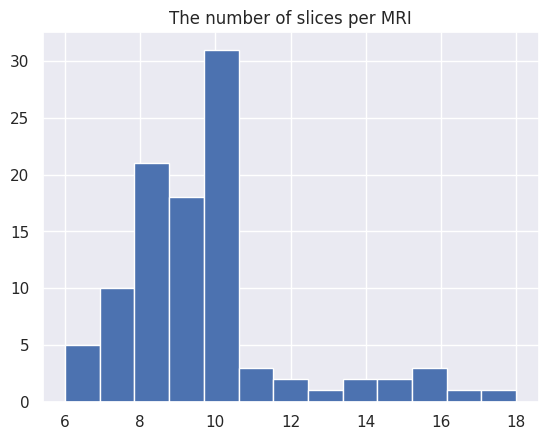

The median number of slices per MRI is: 9.0


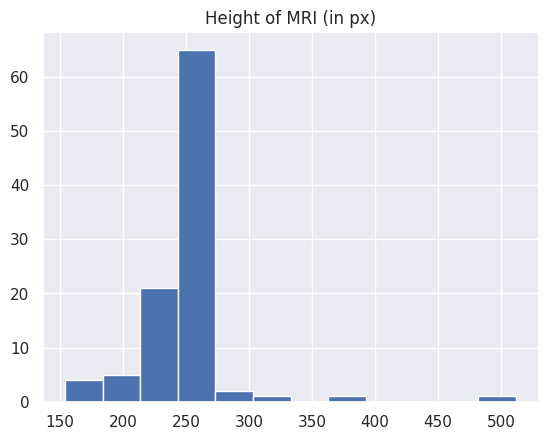

The median height of MRI is: 256.0


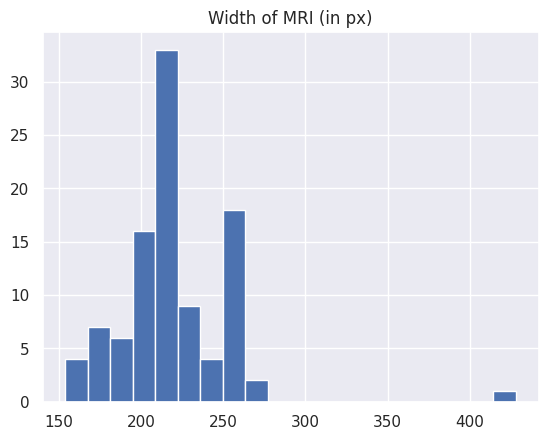

The median width of MRI is: 216.0


In [ ]:
n_slices = np.asarray([data_train[f'{patient_id}']['mri_es'].shape[0] for patient_id in range(1, 101)])

plt.hist(n_slices, bins=len(set(n_slices)))
plt.title('The number of slices per MRI')
plt.show()

print(f'The median number of slices per MRI is: {np.median(n_slices)}')

heights = np.asarray([data_train[f'{patient_id}']['mri_es'].shape[1] for patient_id in range(1, 101)])

plt.hist(heights, bins=len(set(heights)))
plt.title('Height of MRI (in px)')
plt.show()

print(f'The median height of MRI is: {np.median(heights)}')

widths = np.asarray([data_train[f'{patient_id}']['mri_es'].shape[2] for patient_id in range(1, 101)])

plt.hist(widths, bins=len(set(widths)))
plt.title('Width of MRI (in px)')
plt.show()

print(f'The median width of MRI is: {np.median(widths)}')

So we have disparate MRI. It's not a problem if we don't use Deep Learning, and in this case we should put every MRI in the same size. For the moment we do nothing and we continue to work with these MRI.

Let's see how are disperse the category of disease in the training set.

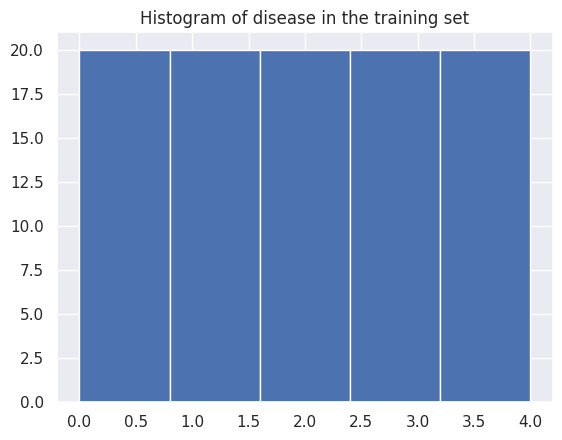

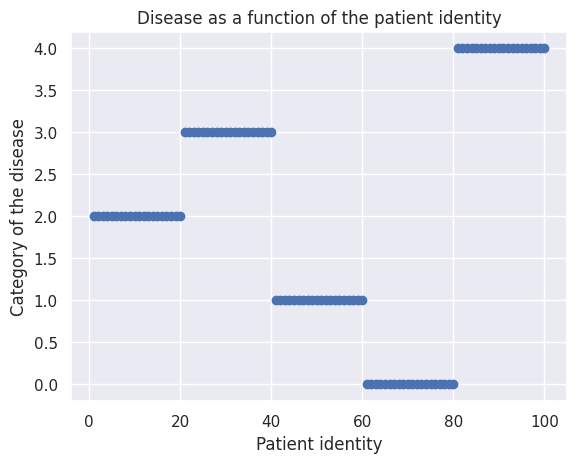

In [ ]:
plt.title('Histogram of disease in the training set')
plt.hist([data_train[f'{patient_id}']['category'] for patient_id in range(1, 101)], bins=5)
plt.show()
plt.title('Disease as a function of the patient identity')
plt.scatter(range(1, 101), [data_train[f'{patient_id}']['category'] for patient_id in range(1, 101)])
plt.xlabel('Patient identity')
plt.ylabel('Category of the disease')
plt.show()

We see that we have as many patients in each category and they are gather in the database.

Now, to see well the MRI, we create a function to plot 3d images.

In [ ]:
def plot_slices(num_rows, num_columns, image):
  '''
  Plot a 3D image slice after slice

  Args:
  num_rows (int): number of rows on the display
  num_columns (int): number of columns on the display
  image (3d array): the image to plot

  Returns:
  Nothing 
  '''

  size = image.shape[1:]
  fig_width = 13
  fig_height = (fig_width / num_columns) / (size[1] / size[0]) * num_rows

  fig, ax = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(fig_width, fig_height))

  if num_rows > 1:
    for i in range(num_rows):
      for j in range(num_columns):
        try:
          ax[i, j].imshow(image[i*num_columns+j], cmap='gray')
          ax[i, j].axis("off")
        except:
          pass
  else:
    for j in range(num_columns):
      try:
        ax[j].imshow(image[j], cmap='gray')
        ax[j].axis("off")
      except:
        pass
      
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.show()

Let's plot some masks from the train set to see what it looks.

The class of this patient is 2


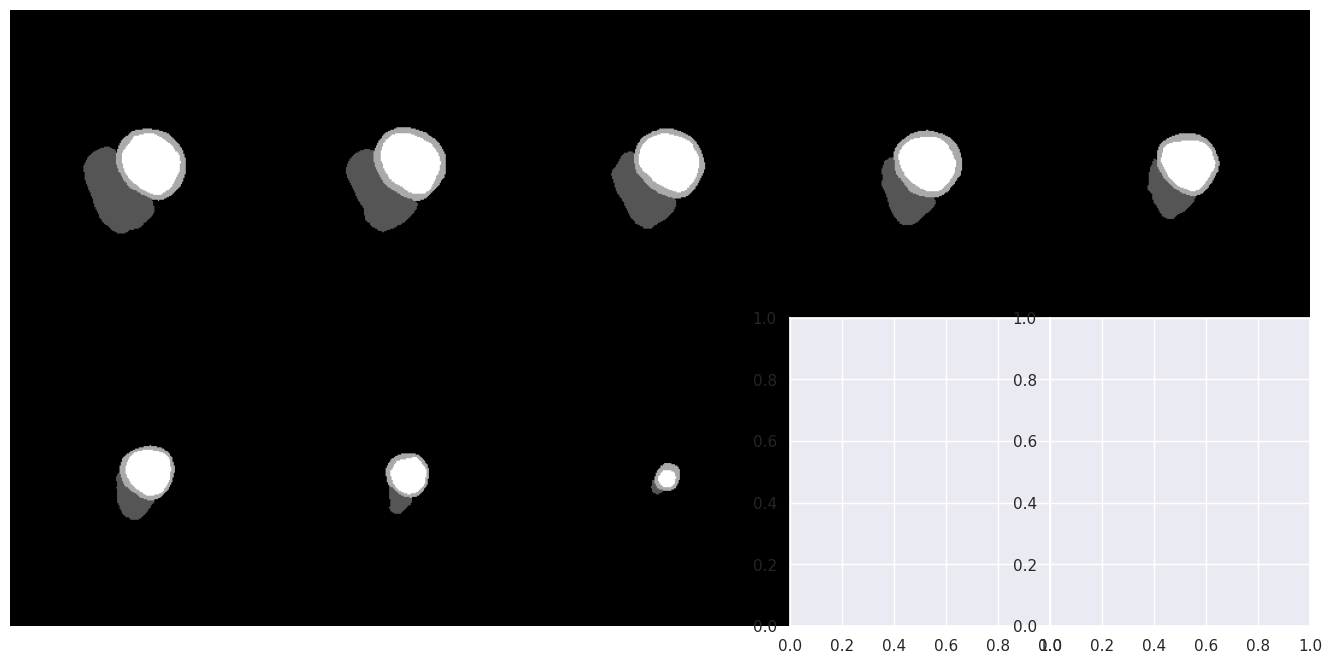

In [ ]:
random_patient_id = np.random.randint(low=1, high=101)
print(f"The class of this patient is {data_train[f'{random_patient_id}']['category']}")
plot_slices(2, 5, data_train[f'{random_patient_id}']['mask_ed'])

Now let's plot some masks from the test set to see what we have to do

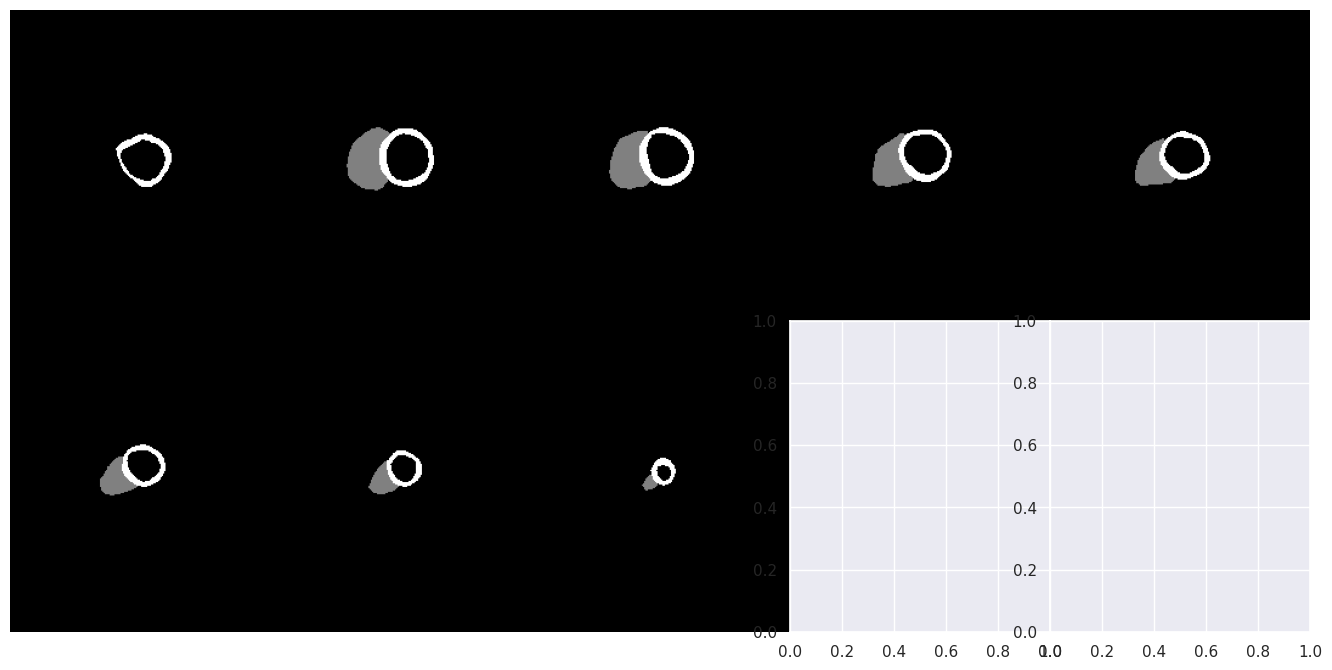

In [ ]:
random_patient_id = np.random.randint(low=101, high=151)
plot_slices(2, 5, data_test[f'{random_patient_id}']['mask_ed'])

## 3.2 Segmentation of the left ventricule

The left ventricule is in white in the train images and we observe that it's always surrounded by the myocardium. Thus a way to segment the left ventricule is simply to fill the myocardium.

To do that we will, slice after slice:

*   Get the interior edge of the myocardium
*   Fill inside this edge


In [ ]:
def segmentate_lv(partial_segmentation):
  '''
  Segment the left ventricule

  Args: 
  partial_segmentation (3d array): partial segmentations of the heart (only the myocardium and the right ventricule)

  Returns:
  complete_segmentation (3d array): Complete segmentation
  ''' 
  
  complete_segmentation = np.zeros_like(partial_segmentation)

  # We complete the segmentation slice after slice
  for i, mask in enumerate(partial_segmentation):

    # We extract the edges of the myocardium 
    edges = canny((mask == 2))
    labels = measure.label(edges, background=0)
    component_sizes = np.bincount(labels.ravel())

    # If there is no myocardium on the slice -> no left ventricule neither
    if len(component_sizes[1:]) == 0:
      complete_segmentation[i] = mask

    # Else there is the myocardium on the slice  
    else:

      # We keep only the smallest component that refers to the interior edge
      smallest_component_label = np.argmin(component_sizes[1:3]) + 1 # '1:3' is here to eliminate the background and the false edges detected with canny
      smallest_component = np.zeros_like(labels)
      smallest_component[labels == smallest_component_label] = 1

      # We now fill inside the myocardium
      fill_image = ndi.binary_fill_holes(smallest_component)

      # We put the left ventricule mask with 3 on the complete segmentation 
      fill_image = fill_image.astype('int')
      fill_image = (3*fill_image) / fill_image.max()
      segm = fill_image + mask
      segm[smallest_component == 1] = 2

      complete_segmentation[i] = segm

  return complete_segmentation

100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


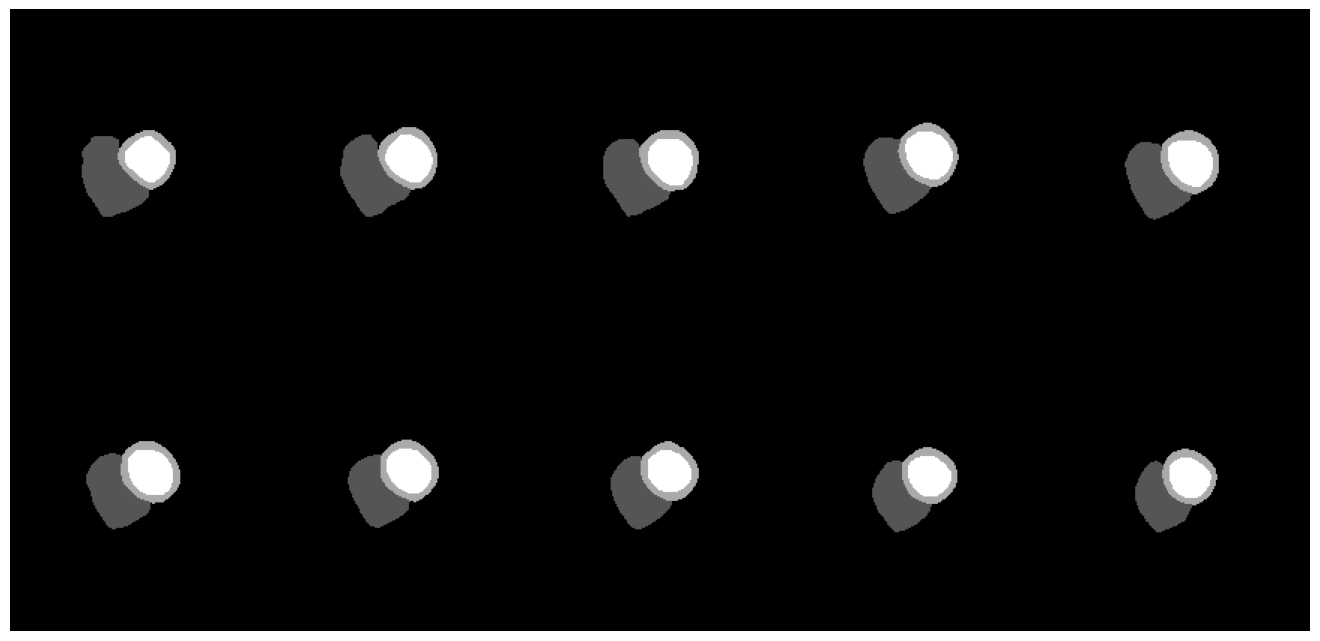

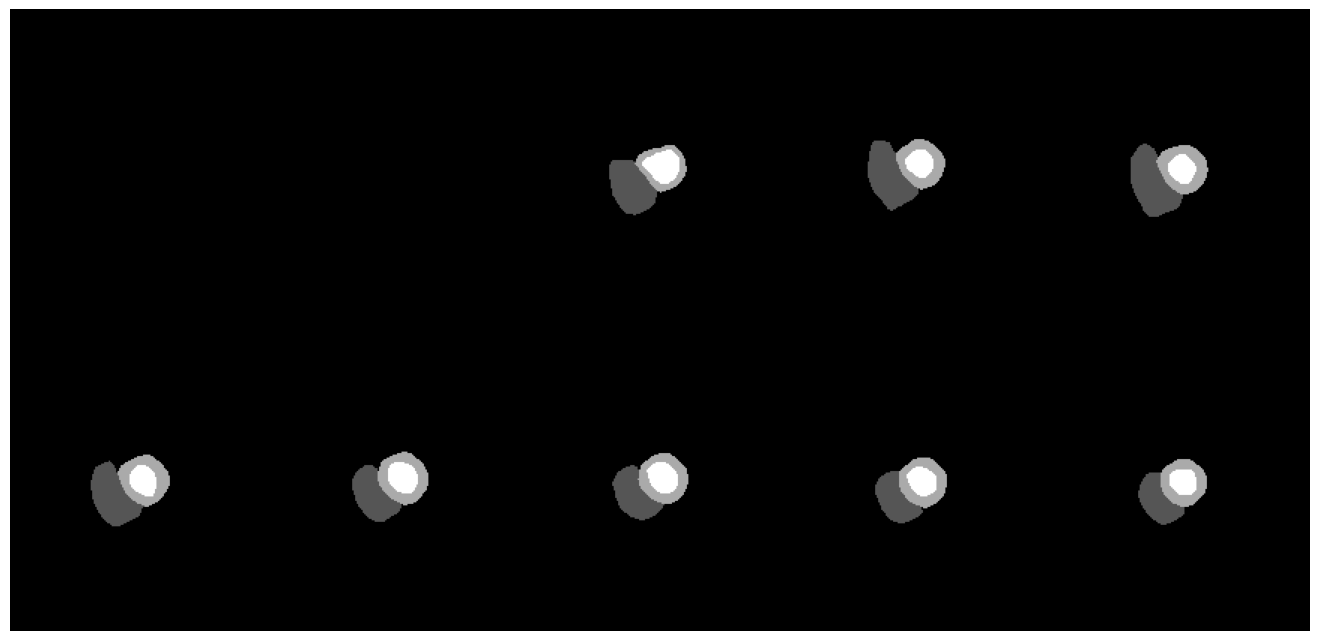

In [ ]:
# We perform the segmentation of the left ventricule
for patient_id in tqdm(range(101, 151)):
  data_test[f'{patient_id}']['mask_ed'] = segmentate_lv(data_test[f'{patient_id}']['mask_ed'])
  data_test[f'{patient_id}']['mask_es'] = segmentate_lv(data_test[f'{patient_id}']['mask_es'])

# We show the result on a random test patient
random_patient_id = np.random.randint(low=101, high=151)
plot_slices(2, 5, data_test[f'{random_patient_id}']['mask_ed'])
plot_slices(2, 5, data_test[f'{random_patient_id}']['mask_es'])

It seems to work very well! Now we can do the extraction of features based on these segmentations. 

# 4. Extraction of some features (handmade)

Taking a look at some papers and we immediatly see that the most important features are extracted based on segmentations of the parts of the heart. We then extract some quantitative values from these segmentations and used by doctors to diagnosis. 

Each patient will first have 17 features which are:

*   Height
*   Weight
*   BMI
*   Volume of the left ventricule at the end of the diastole $V(\text{LV}_\text{e-d})$
*   Volume of the left ventricule at the end of the systole $V(\text{LV}_\text{e-s})$
*   Volume of the right ventricule at the end of the diastole $V(\text{RV}_\text{e-d})$
*   Volume of the right ventricule at the end of the systole $V(\text{RV}_\text{e-s})$
*   Volume of the myocardium at the end of the diastole $V(\text{MYO}_\text{e-d})$
*   Volume of the myocardium at the end of the systole $V(\text{MYO}_\text{e-s})$
*   The ratio between RV and LV volume at ED: $\frac{V(\text{RV}_\text{e-d})}{V(\text{LV}_\text{e-d})}$
*   The ratio between RV and LV volume at ES: $\frac{V(\text{RV}_\text{e-s})}{V(\text{LV}_\text{e-s})}$
*   The ratio between myocardial and LV volume at ED: $\frac{V(\text{MYO}_\text{e-d})}{V(\text{LV}_\text{e-d})}$
*   The ratio between myocardial and LV volume at ES: $\frac{V(\text{MYO}_\text{e-s})}{V(\text{LV}_\text{e-s})}$
*   The LV ejection fraction defined as $\frac{V(\text{LV}_\text{e-d}) - V(\text{LV}_\text{e-s})}{V(\text{LV}_\text{e-d})}$
*   The RV ejection fraction defined as $\frac{V(\text{RV}_\text{e-d}) - V(\text{RV}_\text{e-s})}{V(\text{RV}_\text{e-d})}$
*   The thickness of the myocardium at ED
*   The thickness of the myocardium at ES

We see that, except the first three features, they are all based on the shape of the ventricular cavities.

We don't take acount of the intensity for example. We will take these sort of features into account further in the notebook.

Many of these features is dimensional, so we have to take account the pixel spacing and the voxel size of each MRI. Hopefully, we already put them on the database!

Let's create the easiest feature: the BMC

In [ ]:
# bmc on the trainset
for patient_id in tqdm(range(1, 101)):
  data_train[f"{patient_id}"]["bmc"] = data_train[f"{patient_id}"]["weight"] / (data_train[f"{patient_id}"]["height"] ** 2)

################################################################################

# bmc on the testset
for patient_id in tqdm(range(101, 151)):
  data_test[f"{patient_id}"]["bmc"] = data_test[f"{patient_id}"]["weight"] / (data_test[f"{patient_id}"]["height"] ** 2)

100%|██████████| 50/50 [00:00<00:00, 166970.70it/s]


Let's visualize the first features to see if they are relevant. To do that we plot the weight as function of the height using color based on the category.

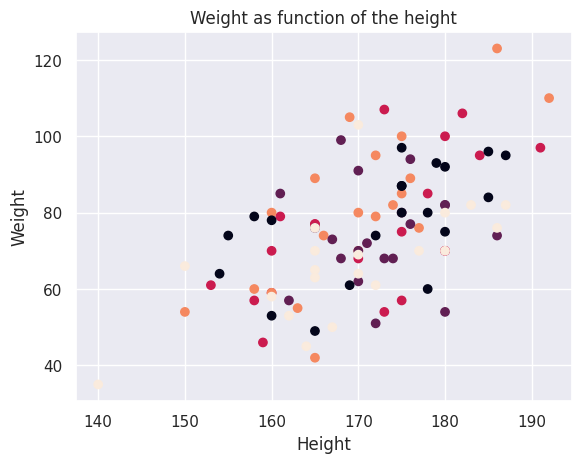

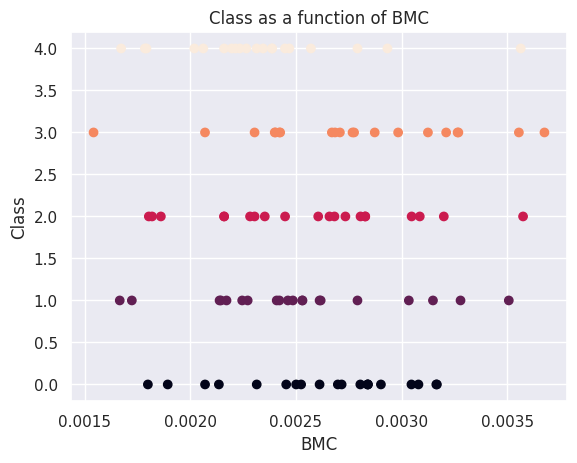

In [ ]:
cmap = [data_train[f'{patient_id}']['category'] for patient_id in range(1, 101)]

plt.title('Weight as function of the height')
plt.scatter([data_train[f'{patient_id}']['height'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['weight'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

plt.title('Class as a function of BMC')
plt.scatter([data_train[f'{patient_id}']['bmc'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['category'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('BMC')
plt.ylabel('Class')
plt.show()

We can't really distinguish some clusters that helped to clasify. These features seem irrelevants.

Let's now get the volume of each cavities at ED and ES.

In [ ]:
def get_volume(mask, voxel_size):
  '''
  Compute the volume of the mask

  Args:
  mask (3d array): Mask of the ROI which we want the volume
  voxel_size (float): The physicial voxel size of 1 voxel

  Returns:
  volume (float): The volume of the ROI indicated with the input mask
  '''

  n_voxels = np.count_nonzero(mask)
  volume = n_voxels * voxel_size

  return volume

In [ ]:
# get_volume on the trainset
for patient_id in tqdm(range(1, 101)):
  data_train[f"{patient_id}"]["volume_lv_ed"] = get_volume((data_train[f"{patient_id}"]["mask_ed"] == 3), data_train[f"{patient_id}"]["voxel_size"])
  data_train[f"{patient_id}"]["volume_myo_ed"] = get_volume((data_train[f"{patient_id}"]["mask_ed"] == 2), data_train[f"{patient_id}"]["voxel_size"])
  data_train[f"{patient_id}"]["volume_rv_ed"] = get_volume((data_train[f"{patient_id}"]["mask_ed"] == 1), data_train[f"{patient_id}"]["voxel_size"])
  data_train[f"{patient_id}"]["volume_lv_es"] = get_volume((data_train[f"{patient_id}"]["mask_es"] == 3), data_train[f"{patient_id}"]["voxel_size"])
  data_train[f"{patient_id}"]["volume_myo_es"] = get_volume((data_train[f"{patient_id}"]["mask_es"] == 2), data_train[f"{patient_id}"]["voxel_size"])
  data_train[f"{patient_id}"]["volume_rv_es"] = get_volume((data_train[f"{patient_id}"]["mask_es"] == 1), data_train[f"{patient_id}"]["voxel_size"])

################################################################################

# get_volume on the testset
for patient_id in tqdm(range(101, 151)):
  data_test[f"{patient_id}"]["volume_lv_ed"] = get_volume((data_test[f"{patient_id}"]["mask_ed"] == 3), data_test[f"{patient_id}"]["voxel_size"])
  data_test[f"{patient_id}"]["volume_myo_ed"] = get_volume((data_test[f"{patient_id}"]["mask_ed"] == 2), data_test[f"{patient_id}"]["voxel_size"])
  data_test[f"{patient_id}"]["volume_rv_ed"] = get_volume((data_test[f"{patient_id}"]["mask_ed"] == 1), data_test[f"{patient_id}"]["voxel_size"])
  data_test[f"{patient_id}"]["volume_lv_es"] = get_volume((data_test[f"{patient_id}"]["mask_es"] == 3), data_test[f"{patient_id}"]["voxel_size"])
  data_test[f"{patient_id}"]["volume_myo_es"] = get_volume((data_test[f"{patient_id}"]["mask_es"] == 2), data_test[f"{patient_id}"]["voxel_size"])
  data_test[f"{patient_id}"]["volume_rv_es"] = get_volume((data_test[f"{patient_id}"]["mask_es"] == 1), data_test[f"{patient_id}"]["voxel_size"])

100%|██████████| 50/50 [00:00<00:00, 959.73it/s]


We can visualize the volume of each cavities to see a correlation with the category. Then we plot $V(\text{ROI}_\text{e-s})$ as a function of $V(\text{ROI}_\text{e-d})$ using color based on the category

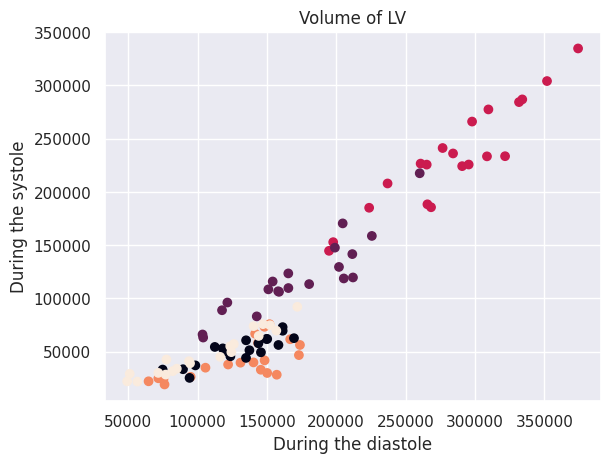

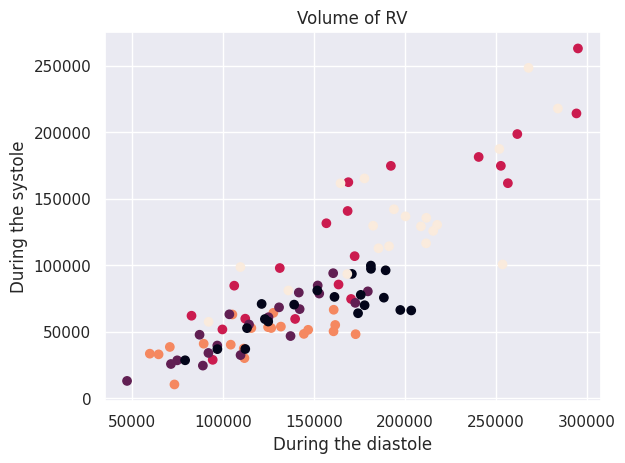

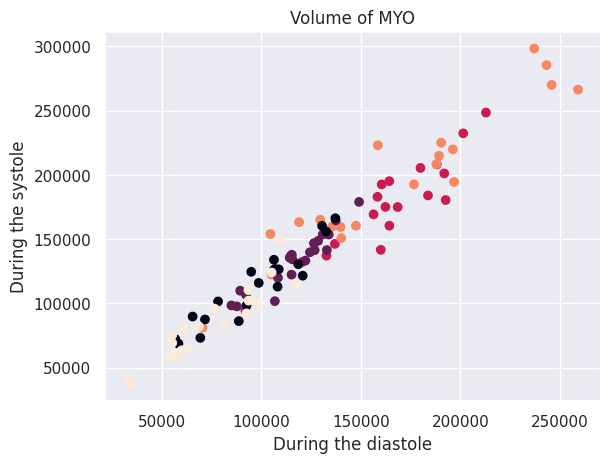

In [ ]:
plt.title('Volume of LV')
plt.scatter([data_train[f'{patient_id}']['volume_lv_ed'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['volume_lv_es'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('During the diastole')
plt.ylabel('During the systole')
plt.show()

plt.title('Volume of RV')
plt.scatter([data_train[f'{patient_id}']['volume_rv_ed'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['volume_rv_es'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('During the diastole')
plt.ylabel('During the systole')
plt.show()

plt.title('Volume of MYO')
plt.scatter([data_train[f'{patient_id}']['volume_myo_ed'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['volume_myo_es'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('During the diastole')
plt.ylabel('During the systole')
plt.show()

We easily see that some of these features seem really interesting to classify.

Let's compute the ratios.

In [ ]:
# ratios on the trainset
for patient_id in tqdm(range(1, 101)):
  data_train[f"{patient_id}"]["rv_over_lv_ed"] = data_train[f"{patient_id}"]["volume_rv_ed"] / data_train[f"{patient_id}"]["volume_lv_ed"]
  data_train[f"{patient_id}"]["rv_over_lv_es"] = data_train[f"{patient_id}"]["volume_rv_es"] / data_train[f"{patient_id}"]["volume_lv_es"]
  data_train[f"{patient_id}"]["myo_over_lv_ed"] = data_train[f"{patient_id}"]["volume_myo_ed"] / data_train[f"{patient_id}"]["volume_lv_ed"]
  data_train[f"{patient_id}"]["myo_over_lv_es"] = data_train[f"{patient_id}"]["volume_myo_es"] / data_train[f"{patient_id}"]["volume_lv_es"]

################################################################################

# ratios on the testset
for patient_id in tqdm(range(101, 151)):
  data_test[f"{patient_id}"]["rv_over_lv_ed"] = data_test[f"{patient_id}"]["volume_rv_ed"] / data_test[f"{patient_id}"]["volume_lv_ed"]
  data_test[f"{patient_id}"]["rv_over_lv_es"] = data_test[f"{patient_id}"]["volume_rv_es"] / data_test[f"{patient_id}"]["volume_lv_es"]
  data_test[f"{patient_id}"]["myo_over_lv_ed"] = data_test[f"{patient_id}"]["volume_myo_ed"] / data_test[f"{patient_id}"]["volume_lv_ed"]
  data_test[f"{patient_id}"]["myo_over_lv_es"] = data_test[f"{patient_id}"]["volume_myo_es"] / data_test[f"{patient_id}"]["volume_lv_es"]

100%|██████████| 50/50 [00:00<00:00, 93706.52it/s]


Let's to the same thing to visualize.

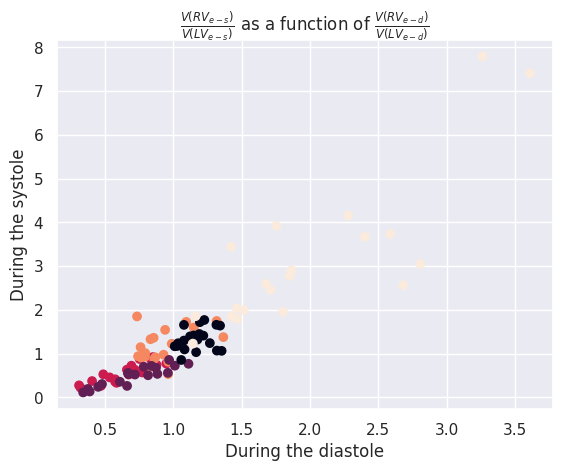

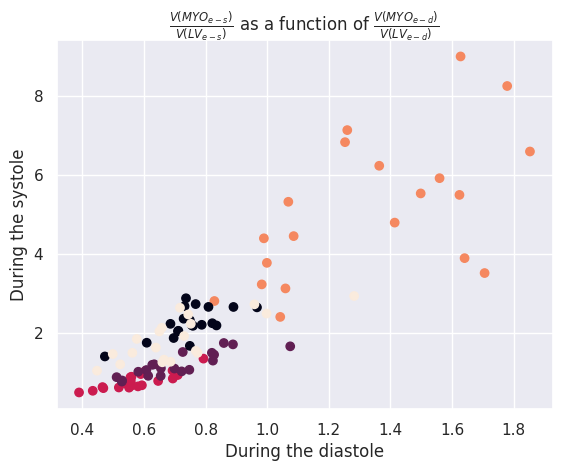

In [ ]:
plt.title(r'$\frac{V(RV_{e-s})}{V({LV}_{e-s})}$ as a function of $\frac{V({RV}_{e-d})}{V({LV}_{e-d})}$')
plt.scatter([data_train[f'{patient_id}']['rv_over_lv_ed'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['rv_over_lv_es'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('During the diastole')
plt.ylabel('During the systole')
plt.show()

plt.title(r'$\frac{V(MYO_{e-s})}{V({LV}_{e-s})}$ as a function of $\frac{V({MYO}_{e-d})}{V({LV}_{e-d})}$')
plt.scatter([data_train[f'{patient_id}']['myo_over_lv_ed'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['myo_over_lv_es'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('During the diastole')
plt.ylabel('During the systole')
plt.show()

Same, we can distinguish some classes thanks to these features.

We can now also compute the LV and RV ejection fraction.

In [ ]:
def get_ejection_fraction(V_ed, V_es):
  '''
  Compute the ejection fraction

  Args:
  V_ed (float): Volume of the ventricular cavity during the ED
  V_es (float): Volume of the ventricular cavity during the ES

  Returns:
  ejection_fraction (float): The ejection fraction
  '''
  return (V_ed - V_es) / V_ed

In [ ]:
# LV and RV ejection fraction on the train set
for patient_id in tqdm(range(1, 101)):
  data_train[f"{patient_id}"]["lv_ejec_frac"] = get_ejection_fraction(data_train[f"{patient_id}"]["volume_lv_ed"], data_train[f"{patient_id}"]["volume_lv_es"])
  data_train[f"{patient_id}"]["rv_ejec_frac"] = get_ejection_fraction(data_train[f"{patient_id}"]["volume_rv_ed"], data_train[f"{patient_id}"]["volume_rv_es"])

################################################################################

# LV and RV ejection fraction on the test set
for patient_id in tqdm(range(101, 151)):
  data_test[f"{patient_id}"]["lv_ejec_frac"] = get_ejection_fraction(data_test[f"{patient_id}"]["volume_lv_ed"], data_test[f"{patient_id}"]["volume_lv_es"])
  data_test[f"{patient_id}"]["rv_ejec_frac"] = get_ejection_fraction(data_test[f"{patient_id}"]["volume_rv_ed"], data_test[f"{patient_id}"]["volume_rv_es"])

100%|██████████| 50/50 [00:00<00:00, 129694.00it/s]


Let's visualize their importance.

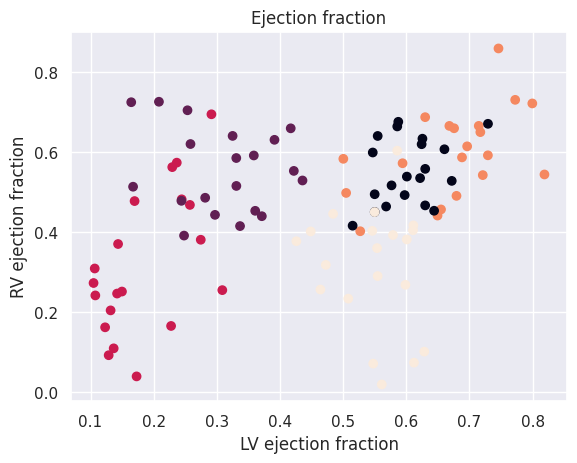

In [ ]:
plt.title('Ejection fraction')
plt.scatter([data_train[f'{patient_id}']['lv_ejec_frac'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['rv_ejec_frac'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('LV ejection fraction')
plt.ylabel('RV ejection fraction')
plt.show()

We can see some clusters that shows us that they are relevant features.

Now let's compute the thickness of the myocardium, a very important feature. To do that we search the thickness of the myocardium in all slices and then we take the maximum. On a slice, we use the edges of the myocardium in and we apply the function distance_transform_edt that will compute the exact distance of the edges from other edges. 

Note: there could be some artefacts of false edges with the function canny, but they appear where the thickness is small, so all in all it doesn't affect the final result.

In [ ]:
def get_myocardium_thickness(mask, pixel_spacing):
  '''
  Compute the thickness of the myocardium

  Args:
  mask (3d array): Mask of the heart
  pixel_spacing (3d array): Physical pixel spacing in all dimension

  Returns:
  thickness (float): Myocardium thickness
  '''

  mask_myo = (mask == 2)
  thickness = 0
  for mask_myo_slice in mask_myo:
    # We avoid to deal with slices where they're not myocardium
    if mask_myo_slice.max() > 0:
      edges = canny(mask_myo_slice)
      dist_transform = distance_transform_edt(~edges, sampling=pixel_spacing[:2])
      thickness = max(np.max(mask_myo_slice*dist_transform), thickness)
    
  return thickness

In [ ]:
# thickness of the myocaridum on the train set
for patient_id in tqdm(range(1, 101)):
  data_train[f"{patient_id}"]["myo_thickness_ed"] = get_myocardium_thickness(data_train[f"{patient_id}"]["mask_ed"], data_train[f"{patient_id}"]["pixel_spacing"])
  data_train[f"{patient_id}"]["myo_thickness_es"] = get_myocardium_thickness(data_train[f"{patient_id}"]["mask_es"], data_train[f"{patient_id}"]["pixel_spacing"])

################################################################################

# thickness of the myocaridum on the test set
for patient_id in tqdm(range(101, 151)):
  data_test[f"{patient_id}"]["myo_thickness_ed"] = get_myocardium_thickness(data_test[f"{patient_id}"]["mask_ed"], data_test[f"{patient_id}"]["pixel_spacing"])
  data_test[f"{patient_id}"]["myo_thickness_es"] = get_myocardium_thickness(data_test[f"{patient_id}"]["mask_es"], data_test[f"{patient_id}"]["pixel_spacing"])


100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Let's visualize if they are good features or not

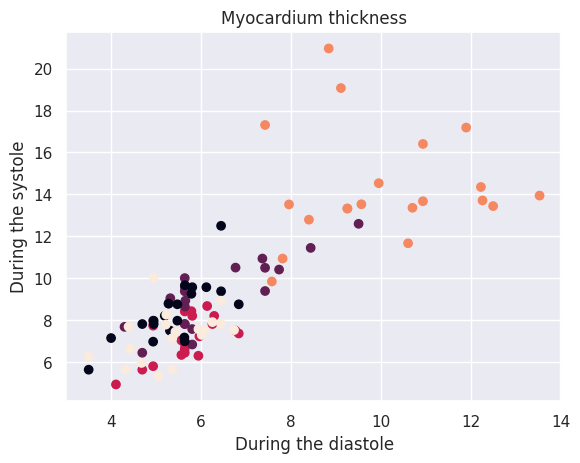

In [ ]:
plt.title('Myocardium thickness')
plt.scatter([data_train[f'{patient_id}']['myo_thickness_ed'] for patient_id in range(1, 101)], [data_train[f'{patient_id}']['myo_thickness_es'] for patient_id in range(1, 101)], c=cmap)
plt.xlabel('During the diastole')
plt.ylabel('During the systole')
plt.show()

We can see that the myocardium thickness helps a lot to detect one class: the myocardial infarction.

# 5. Classification with handmade features

Now that we have our features, we can test different techniques to classify our data. 

We will test few techniques of classification with ML and we will then determine which one is the better. Why do we not use Deep Learning ? Because we have not enough data do to, we would either underfit or overfit if we do that. 

So we will perform, thanks to GridSearchCV to find the best hyperparameters:

*   Linear Discriminant Analysis
*   Support Vector Machine
*   k-Nearest Neighbors
*   RandomForest
*   XGBoost

## 5.1. Methodology

We chose the accuracy as a metric of evaluation because this is the case for the kaggle challenge and we have data evenly separated (the same number of each class) 

To test the efficiency of different algorithms we will search the best hyperparameters thanks to GridSearchCV with all the train set (because it searches with crossvalidation so it automatically split our train set into a new train set and a validation set). We will chose the best hyperparameters by doing the GridSearchCV a bunch of times and weighted with the best validation score. By weighting it with the best validation score, we will favour the hyperparameters which enable to get the best validation score (that is something we want to avoid overfitting!). However, we have to be careful and not score each parameter separately because we vote for a combination of hyperparameters! A naive method would be to vote for all combination and take the one with the more votes as if all combination were independant. That is not stupid and I think it would work most of the times. But sometimes it could be a problem. For example, let's take the case of doing GridSearchCV with a RandomForest to search for the best value for n_estimator and min_samples_leaf. If the votes are 5 for the combination {n_estimator=10, min_samples_leaf=6}, 4 for {n_estimator=800, min_samples_leaf=2}, 4 for {n_estimator=700, min_samples_leaf=2} and 4 for {n_estimator=800, min_samples_leaf=3}, the naive method would chose the combination {n_estimator=10, min_samples_leaf=6} rather than {n_estimator=800, min_samples_leaf=2} which seems more adapted.

So if we can capture the link between all the parameters, we could avoid this type of problem. And for that we can use the distance in the space of hyperparameters (1 dimension for 1 hyperparameter to chose). The distance will depend on the indices and not the value. For example, the distance between {min_sample_leaf=2, n_estimator=10} and {min_samples_leaf=6, n_estimator=1000} in the space 

|  | n_estimator=10 | n_estimator=1000 |
| --- | --- | --- |
| **min_samples_leaf=2** | min_samples_leaf=2, n_estimator=10 | min_samples_leaf=2, n_estimator=1000 |
| **min_samples_leaf=6** | min_samples_leaf=6, n_estimator=10 | min_samples_leaf=6, n_estimator=1000 |


is lower ($=\sqrt{2}$) than the distance in the space

|  | n_estimator=10 | n_estimator=100 | n_estimator=1000 |
| --- | --- | --- | --- |
| **min_samples_leaf=2** | min_samples_leaf=2, n_estimator=10 | min_samples_leaf=2, n_estimator=100 | min_samples_leaf=2, n_estimator=1000 |
| **min_samples_leaf=6** | min_samples_leaf=6, n_estimator=10 | min_samples_leaf=6, n_estimator=100 | min_samples_leaf=6, n_estimator=1000 |

And that is not a problem, that is exactly what we want. However we have to be aware of that and put reasonable values (without discontinuity) in the parameter grid search. However in the second space, we all agree that the distance betwee two columns worths less than the distance between two lines. To convince yourself, change the min_smaples_leaf to something with a boolean value and extend the number of columns with the same range. In the case of the second case, we could create the real distance by creating a virtual line between the first line and a second line. It will look like that 

|  | n_estimator=10 | n_estimator=100 | n_estimator=1000 |
| --- | --- | --- | --- |
| **min_samples_leaf=2** | min_samples_leaf=2, n_estimator=10 | min_samples_leaf=2, n_estimator=100 | min_samples_leaf=2, n_estimator=1000 |
| **virtual line** | nothing | nothing | nothing | nothing | 
| **min_samples_leaf=6** | min_samples_leaf=6, n_estimator=10 | min_samples_leaf=6, n_estimator=100 | min_samples_leaf=6, n_estimator=1000 |

This is a good case to visualize that, but in the real world we resize each dimension of hyperparameters by taking the reference one the maximum dimensional length.

So we have all the votes for each combination and a quantitative measure of how near is a combination from the others. Now we can count the vote for any combination $c_i$ by taking account the votes of every combination in the ball of center $c_i$ and radius $r$ by scaling them with a gaussian: $$ \text{vote}(c_i) = \sum _{c_k ∈ B_r(c_i)} \text{vote}(c_k) e^{-\text{d}(c_i, c_k) / σ^2}$$ 


Notes: 

(1) For the simplicity we take the distance of the ∞ norm because we can compute it very easily thanks to a convolution.

(2) During the challenge I did not have this function, but I had this reflexion so I did it by hand by repeating many times the GridSearchCV to get the parameters.


Once we get the best hyperparameters, we evaluate the model by spliting our train set in two sets (a train set and a validation set), training the model with the new train set and evaluating on the validation set. We also do that a bunch of times and then we compute the average of the accuracy and we obtain a great quantitative measure of the efficiency of the model. Why do we take the average of everything ? Because algorithms are random and it keep fluctuating around a value (especially the Random Forest algorithm). We want to avoid that and to have directly the right value. For example it could be very useful when we will want to chose the right amount of features.

Linked to the last point, it appears sensible to do the average on n_iter validation scores where n_iter is in the same range of the number of samples per class in the train set. For example if we chose to have val_size = 0.3 then we got 30 samples in the validation set. When we split evenly we have 6 samples per class in the validation set and 14 samples per class in the train set. And I suppose that doing the average on 14 validation scores is very good. 


Thus, to do that we need a function to split evenly the train set. And we need another function to search hyperparameters using GridSearchCV.

And we need a final function to evaluate the model.

Let's code these 3 functions here.

In [ ]:
def train_val_split(X, y, val_size=0.3, n_classes=5):
  '''
  Split into a train set and a validation set evenly
  
  Args:
  X (array): Features
  y (1d array): Class

  Returns:
  X_train, X_val, y_train, y_val
  '''

  n_val_class = int((val_size * X.shape[0]) / n_classes) # Number of samples in the validation set for a class
  n_train_class = X.shape[0] // n_classes - n_val_class # Number of samples in the train set for a class

  X_train = np.empty((n_train_class * n_classes, X.shape[1]))
  y_train = np.empty(n_train_class * n_classes)
  X_val = np.empty((n_val_class * n_classes, X.shape[1]))
  y_val = np.empty(n_val_class * n_classes)

  for n_class in range(n_classes):
    indices_train= np.random.choice(X.shape[0] // n_classes, n_train_class, replace=False) + n_class * 20
    indices_val = np.setdiff1d(np.arange(n_class * (X.shape[0] // n_classes), (n_class+1) * (X.shape[0] // n_classes)), indices_train)
    X_train[n_class * n_train_class: (n_class+1) * n_train_class] = X[indices_train]
    y_train[n_class * n_train_class: (n_class+1) * n_train_class] = y[indices_train]
    X_val[n_class * n_val_class: (n_class+1) * n_val_class] = X[indices_val]
    y_val[n_class * n_val_class: (n_class+1) * n_val_class] = y[indices_val]
  
  return X_train, X_val, y_train, y_val

In [ ]:
def get_best_hypperparameters(model, p_grid, X, y, n_grid_search_cv=25, radius=1, sigma=1):
  '''
  Return the best hyperparameters 

  Args:
  model: The ML model
  p_grid: A dictionary of the potential hyperparameters
  X: Features
  y: Class
  n_grid_search_cv: The number of GridSearchCV we want to do
  radius: The radius of the ball (/ max length)
  sigma: The std deviation of the gaussian kernel

  Returns:
  best_param (dict): Best hyperparameters 
  '''
  
  dimensional_length = np.asarray([len(p_grid[key]) for key in p_grid.keys()])
  ind_max_length = np.argmax(dimensional_length)
  
  new_radius = radius * np.prod(np.delete(dimensional_length, ind_max_length)) # The radius in the new space
  
  length_dim = np.prod(dimensional_length) # The number of 'parameters' in each dimension in the new space.

  param_space = np.zeros((length_dim,) * len(dimensional_length))

  factor_dim = np.asarray([np.prod(np.delete(dimensional_length, ind_dim)) for ind_dim in range(len(dimensional_length))]) # The factor use to rescale everything

  # Now we train our grid search cv a bunch of times
  for i in tqdm(range(n_grid_search_cv)): # I put tqdm because it could be very long
    grid_search_cv = GridSearchCV(estimator=model, param_grid=p_grid, scoring="accuracy", cv=5)
    grid_search_cv.fit(X, y)

    # We get the best validation score with the best parameters
    val_score = grid_search_cv.best_score_
    params = grid_search_cv.best_params_

    # We search the indexes of hyperparameters in each dimensions
    indeces_new_space = [] # Indexes in the new space
    for i, key in enumerate(p_grid.keys()):
      ind = p_grid[key].index(params[key]) # Index of the corresponding parameter in the dict
      indeces_new_space.append(ind * factor_dim[i])
    
    # We update the score of the right combination
    param_space[tuple(indeces_new_space)] += val_score

  # We compute the score by summing the score of all the component in the ball of radius radius (thanks to convolution)
  # We first create the reducted kernel for the convolution
  #distance_factor = np.prod(np.delete(dimensional_length, ind_max_length)) # All the distance are scaled with it. We have to delete it!
  kernel = np.ones((2*new_radius + 1,) * len(dimensional_length)) 
  for indices in np.ndindex(kernel.shape):
    distance = np.sum((np.asarray(indices) - new_radius * np.ones(len(dimensional_length))) ** 2) # Distance l2 from the center. We divide to normalize
    kernel[indices] = np.exp(- distance / (sigma ** 2))

  # We apply the convolution
  param_space_ball = ndi.convolve(param_space, kernel, mode='constant')
  # We find the best combination in this last space
  indexes_max = np.argmax(param_space_ball) 
  indexes_max_unravel = np.unravel_index(indexes_max, param_space_ball.shape) # Index in the new space
  indexes_max_dict = [indexes_max_unravel[i] // factor_dim[i] for i in range(len(dimensional_length))] # Index in the old space

  # We put that in a dictionary
  best_params = copy.deepcopy(p_grid)
  for index_max_dim, key in zip(indexes_max_dict, p_grid.keys()):
    best_params[key] = p_grid[key][index_max_dim]
  
  return best_params

In [ ]:
def score_model(X, y, model, n_iter=50):
  '''
  That function return the average validation score (between 0 and 1) of a model

  Args:
  X, y: The whole train set
  model: The model to test
  n_iter: The number of times we want to test

  Returns:
  average_val_score: The average of all the validation score
  '''

  cum_val_score = 0 # The cumulate sum of validation score

  for i in range(n_iter): # I put a tqdm here because it could be long

    # We first split our dataset
    X_train, X_val, y_train, y_val = train_val_split(X, y)

    # We fit our model with the train set
    model.fit(X_train, y_train)
    
    # We get the validation score and update cum_val_score
    cum_val_score += model.score(X_val, y_val)
  
  average_val_score = cum_val_score / n_iter

  return average_val_score

## 5.2. Pre-processing

First, we have to put all the features in an adequate numpy array and then to standardize them. Indeed, standardizing data is very useful when we using distance-based algorithm like k-NN or SVM. And standardiznig won't effect others algorithms like RF.

At the same time we will create a function to split our train set into a validation set and a new train set with the same proportion of class in the two of them (i.e. as many of each class present in the two new sets of data).

In [ ]:
# We first put all the features inside a new dictionnnary

keys_to_delete = ['path_mri_ed', 'mri_ed','pixel_spacing', 'voxel_size', 'path_mri_es', 'mri_es', 'path_mask_ed', 'mask_ed', 'path_mask_es', 'mask_es']

# For the train set

features_train_dict = copy.deepcopy(data_train)
for patient_id in range(1, 101):
  for key_to_delete in keys_to_delete:
    try:
      del features_train_dict[f'{patient_id}'][key_to_delete]
    except:
      pass
  try:
    del features_train_dict[f'{patient_id}']['category']
  except:
    pass

################################################################################

# For the test set

features_test_dict = copy.deepcopy(data_test)
for patient_id in range(101, 151):
  for key_to_delete in keys_to_delete:
    try:
      del features_test_dict[f'{patient_id}'][key_to_delete]
    except:
      pass

################################################################################

# We check if there are only features in these dictionnaries
features_test_dict['101'].keys(), features_train_dict['1'].keys()

(dict_keys(['height', 'weight', 'bmc', 'volume_lv_ed', 'volume_myo_ed', 'volume_rv_ed', 'volume_lv_es', 'volume_myo_es', 'volume_rv_es', 'rv_over_lv_ed', 'rv_over_lv_es', 'myo_over_lv_ed', 'myo_over_lv_es', 'lv_ejec_frac', 'rv_ejec_frac', 'myo_thickness_ed', 'myo_thickness_es']),
 dict_keys(['height', 'weight', 'bmc', 'volume_lv_ed', 'volume_myo_ed', 'volume_rv_ed', 'volume_lv_es', 'volume_myo_es', 'volume_rv_es', 'rv_over_lv_ed', 'rv_over_lv_es', 'myo_over_lv_ed', 'myo_over_lv_es', 'lv_ejec_frac', 'rv_ejec_frac', 'myo_thickness_ed', 'myo_thickness_es']))

In [ ]:
# Create a dataframe for the train set

features_train_df = pd.DataFrame.from_dict(features_train_dict, orient='index')
# We convert indexes from string to int to sort by indexes
features_train_df.index = features_train_df.index.astype('int') 
features_train_df.sort_index(inplace=True)

###############################################################################

# Create a dataframe for the test set

features_test_df = pd.DataFrame.from_dict(features_test_dict, orient='index')
features_test_df.index = features_test_df.index.astype('int')
features_test_df.sort_index(inplace=True)

# Plot the head of features_train_df to check everything is good
features_train_df.head()

,height,weight,bmc,volume_lv_ed,volume_myo_ed,volume_rv_ed,volume_lv_es,volume_myo_es,volume_rv_es,rv_over_lv_ed,rv_over_lv_es,myo_over_lv_ed,myo_over_lv_es,lv_ejec_frac,rv_ejec_frac,myo_thickness_ed,myo_thickness_es
1,184.0,95.0,0.002806,295507.812500,164257.812500,139721.679688,225610.351562,195068.359375,59545.898438,0.472819,0.263932,0.555849,0.864625,0.236533,0.573825,5.633674,6.629126
2,160.0,70.0,0.002734,265744.400024,160433.578491,94432.067871,188303.375244,192565.155029,28823.089600,0.355349,0.153067,0.603714,1.022633,0.291412,0.694774,5.800485,8.203125
3,165.0,77.0,0.002828,276708.984375,191845.703125,192333.984375,241088.867188,201074.218750,174584.960938,0.695077,0.724152,0.693312,0.834025,0.128728,0.092282,5.633674,7.812500
4,159.0,46.0,0.001820,260847.091675,168452.453613,106264.114380,226472.473145,174957.275391,84543.991089,0.407381,0.373308,0.645790,0.772532,0.131781,0.204398,5.637058,6.835938
5,165.0,77.0,0.002828,290797.119141,201392.578125,170463.867188,224094.726562,232261.962891,74553.222656,0.586195,0.332686,0.692554,1.036445,0.229378,0.562645,6.288941,8.199776


In [ ]:
# We convert everything in a numpy array

X = features_train_df.to_numpy() # Contains the features of the train set
X_test = features_test_df.to_numpy() # Contains the features of the train set
y = np.asarray([data_train[f'{patient_id}']['category'] for patient_id in range(1, 101)]) # Contains the class of the train set

print(f'There are {X.shape[1]} features')

There are 17 features


Now that we have our features inside numpy arrays, we can standardize them.

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

## 5.3. LDA

In [ ]:
# Hyperparameters to test 
p_grid_lda = {'solver': ['svd', 'lsqr', 'eigen']}
lda = LinearDiscriminantAnalysis()

# Get the best hyperparameters with my function
best_params_lda = get_best_hypperparameters(lda, p_grid_lda, X, y)
print(f'\nThe best parameters are: {best_params_lda}')

100%|██████████| 25/25 [00:01<00:00, 14.23it/s]


The best parameters are: {'solver': 'svd'}


Now let's evaluate this model with our another function.

In [ ]:
best_lda = LinearDiscriminantAnalysis(solver=best_params_lda['solver'])
val_score_lda = score_model(X, y, best_lda)
print(f'\nThe score of LDA is: {val_score_lda}')


The score of LDA is: 0.9206666666666663


We obtain a score which seems pretty good but we don't have enough reference at this point, let's continue with others methods.

## 5.4. SVM

We use a non-linear SVM with the radial kernel because we saw in lab that it's always better with it. We search gamma around 1/17 (1/n_features)

In [ ]:
# Hyperparameters to test 
p_grid_svm = {'C': [0.0005, 0.00075, 0.001, 0.003, 0.005, 0.01], 'gamma': ['auto', 0.01, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1]}
svm = SVC(kernel='rbf')

# Get the best hyperparameters with my function
best_params_svm = get_best_hypperparameters(svm, p_grid_svm, X, y)
print(f'\nThe best parameters are: {best_params_svm}')

100%|██████████| 25/25 [00:17<00:00,  1.43it/s]


The best parameters are: {'C': 0.0005, 'gamma': 0.07}


In [ ]:
best_svm = SVC(kernel='rbf', C=best_params_svm['C'], gamma=best_params_svm['gamma'])
val_score_svm = score_model(X, y, best_svm)
print(f'\nThe score of  SVM is: {val_score_svm}')


The score of  SVM is: 0.9266666666666662


The result is better than with LDA.

## 5.5. k-NN

In [ ]:
# Hyperparameters to test 
p_grid_knn = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10]}
knn = KNeighborsClassifier()

# Get the best hyperparameters with my function
best_params_knn = get_best_hypperparameters(knn, p_grid_knn, X, y)
print(f'\nThe best parameters are: {best_params_knn}')

100%|██████████| 25/25 [00:07<00:00,  3.18it/s]


The best parameters are: {'n_neighbors': 3}


In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=best_params_knn['n_neighbors'])
val_score_knn = score_model(X, y, best_knn)
print(f'The score of the k-NN is: {val_score_knn}')

The score of the k-NN is: 0.9053333333333329


The model seems as good as the SVM.

## 5.6. Random Forest

In [ ]:
# Hyperparameters to test 
p_grid_rf = {'n_estimators': [10, 25, 50, 100, 200], 'min_samples_leaf': [2, 3, 4, 5], 'criterion' : ['entropy', 'gini']}   
rf = RandomForestClassifier()

# Get the best hyperparameters with my function
best_params_rf = get_best_hypperparameters(rf, p_grid_rf, X, y)
print(f'\nThe best parameters are: {best_params_rf}')

100%|██████████| 25/25 [12:27<00:00, 29.90s/it]



The best parameters are: {'n_estimators': 25, 'min_samples_leaf': 2, 'criterion': 'entropy'}


In [ ]:
best_rf = RandomForestClassifier(n_estimators=best_params_rf['n_estimators'], min_samples_leaf=best_params_rf['min_samples_leaf'], criterion=best_params_rf['criterion'])
val_score_rf = score_model(X, y, best_rf)
print(f'The score of the RF is: {val_score_rf}')

The score of the RF is: 0.9373333333333329


## 5.7. Prediction

We see that Random Forest seems to be the most adapted Machine Learning model to this classification model.

However, the presence of random in this algorithm makes the prediction random too. So I think that a good way to get the predictions is to predict a lot of times and take the most predicted class for each test patient.

In [ ]:
def get_prediction(model, X_train, y_train, X_test, n_predictions=20, n_class=5):
  y_test = np.zeros((X_test.shape[0], n_class))
  for i in tqdm(range(n_predictions)):
    # We train with all our train set
    model.fit(X_train, y_train)
    # We get the prediction
    y_pred = model.predict(X_test)
    # We update the votes
    for k, pred in enumerate(y_pred):
      y_test[k, pred] += 1
  # We take the class with more votes    
  y_test = y_test.argmax(axis=1) 
  return y_test

In [ ]:
y_test = get_prediction(best_rf, X, y, X_test)

100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


# 6. Extractions of features thanks to Radiomic

PyRadiomics is a library for extracting a large number of quantitative image features from medical imaging data. It includes a wide range of feature extraction algorithms and supports multiple imaging modalities. We have to give as an argument the path of the image and the mask of the region of interest (ROI). And Radiomic's output are a lot of additive features which comprises features based on several categories (I take the descriptions made in [2]):
 

*   Shape based (Volume, surface area, sphericity, compactness, diameters, elongation, etc.)
*    Intensity first order statistics (e.g. mean, standard deviation, energy,
entropy, etc.).
*    Gray level cooccurence matrix (GLCM) (autocorrelation, contrast, dissimilarity, homogeneity, inverse difference moment, maximum probability, etc.).
*    Gray level run length matrix (GLRLM) (short/long run emphasis, graylevel/run-length non-uniformity, etc.).
*    Gray level size zone matrix (GLSZM) (smal/large area emphasis, zone percentage, etc.).

So we understand easily the importance of normalize the image in the ROI. So that's what we have to do in the first place.








## 6.1 Standardization of images in the ROI

We standardize the images in the ROI only because this is the only interested thing for us.

In [ ]:
def get_mean_std(mri, mask):
  '''
  Get the mean and the std in the ROI

  Args:
  mri (3d array): The MRI
  mask (3d array): The mask of the ROI

  Returns:
  mean (float): The mean in the ROI
  std (float): The std in the ROI
  '''

  mask_heart = mask > 0
  intensity_heart = mri[mask_heart].flatten()
  mean = intensity_heart.mean()
  std = intensity_heart.std()
  
  return mean, std

In [ ]:
patient_id=1
get_mean_std(data_train[f'{patient_id}']['mri_ed'], data_train[f'{patient_id}']['mask_ed'])

(205.677540215842, 98.3414761331991)

In [ ]:
mean = np.asarray([get_mean_std(data_train[f'{patient_id}']['mri_ed'], data_train[f'{patient_id}']['mask_ed'])[0] for patient_id in range(1, 101)]).mean()
std = np.asarray([get_mean_std(data_train[f'{patient_id}']['mri_ed'], data_train[f'{patient_id}']['mask_ed'])[1] for patient_id in range(1, 101)]).mean()
print(f'The mean in the ROI is {mean}, and the std is {std}')

The mean in the ROI is 133.6783049718835, and the std is 56.176611648412006


In [ ]:
def standardize(mri, mean, std):
  '''
  Return the MRI standardize
  '''
  return (mri - mean) / std

We update the MRI in data_train and data_test

In [ ]:
# standardization of the MRI in the train set
for patient_id in tqdm(range(1, 101)):
  data_train[f'{patient_id}']['mri_ed'] = standardize(data_train[f'{patient_id}']['mri_ed'], mean, std)
  data_train[f'{patient_id}']['mri_es'] = standardize(data_train[f'{patient_id}']['mri_es'], mean, std)

################################################################################

# standardization of the MRI in the test set
for patient_id in tqdm(range(101, 151)):
  data_test[f'{patient_id}']['mri_ed'] = standardize(data_test[f'{patient_id}']['mri_ed'], mean, std)
  data_test[f'{patient_id}']['mri_es'] = standardize(data_test[f'{patient_id}']['mri_es'], mean, std)

100%|██████████| 50/50 [00:00<00:00, 602.67it/s]


Let's vizualize the means and std of the standardized MRI.

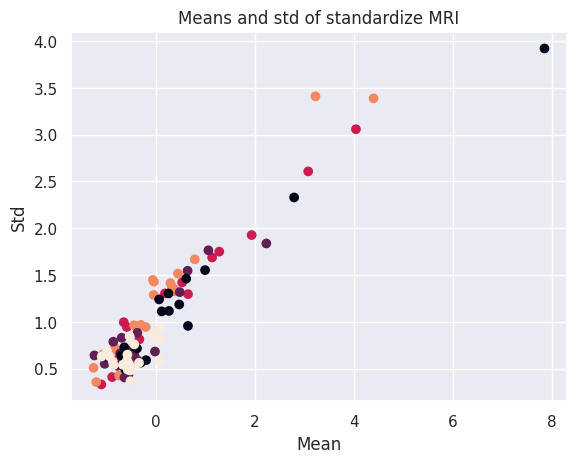

In [ ]:
means = []
stds = []
for patient_id in range(1, 101):
  mean, std = get_mean_std(data_train[f'{patient_id}']['mri_ed'], data_train[f'{patient_id}']['mask_ed'])
  means.append(mean)
  stds.append(std)

plt.scatter(means, stds, c=cmap)
plt.title('Means and std of standardize MRI')
plt.xlabel('Mean')
plt.ylabel('Std')
plt.show()

## 6.2. Feature extractions with Radiomics

Everything looks great, we see that we can't use the mean and standard deviation as a feature to classify.

Now let's save these new MRI and the masks of all the ventricule cavities in new folders.

In [ ]:
# We create new rep to store the path of standardized MRI
!mkdir '{current_rep}/standardized_mri_ed'
!mkdir '{current_rep}/standardized_mri_es'

for patient_id in tqdm(range(1, 101)):

  # ED
  original_mri = sitk.ReadImage(data_train[f'{patient_id}']['path_mri_ed'])
  standardized_mri = sitk.GetImageFromArray(data_train[f'{patient_id}']['mri_ed'])

  # Copy the information from the original image to the new image
  standardized_mri.CopyInformation(original_mri)

  # Save the new images
  sitk.WriteImage(standardized_mri, f'{current_rep}/standardized_mri_ed/{patient_id}.nii')

  # Save the path of these new images
  data_train[f'{patient_id}']['path_standardized_mri_ed'] = f'{current_rep}/standardized_mri_ed/{patient_id}.nii'

  # ES
  original_mri = sitk.ReadImage(data_train[f'{patient_id}']['path_mri_es'])
  standardized_mri = sitk.GetImageFromArray(data_train[f'{patient_id}']['mri_es'])

  # Copy the information from the original image to the new image
  standardized_mri.CopyInformation(original_mri)

  # Save the new images
  sitk.WriteImage(standardized_mri, f'{current_rep}/standardized_mri_es/{patient_id}.nii')

  # Save the path of these new images
  data_train[f'{patient_id}']['path_standardized_mri_es'] = f'{current_rep}/standardized_mri_es/{patient_id}.nii'


for patient_id in tqdm(range(101, 151)):
  # ED
  original_mri = sitk.ReadImage(data_test[f'{patient_id}']['path_mri_ed'])
  standardized_mri = sitk.GetImageFromArray(data_test[f'{patient_id}']['mri_ed'])

  # Copy the information from the original image to the new image
  standardized_mri.CopyInformation(original_mri)

  # Save the new images
  sitk.WriteImage(standardized_mri, f'{current_rep}/standardized_mri_ed/{patient_id}.nii')

  # Save the path of these new images
  data_test[f'{patient_id}']['path_standardized_mri_ed'] = f'{current_rep}/standardized_mri_ed/{patient_id}.nii'

  # ES
  original_mri = sitk.ReadImage(data_test[f'{patient_id}']['path_mri_es'])
  standardized_mri = sitk.GetImageFromArray(data_test[f'{patient_id}']['mri_es'])

  # Copy the information from the original image to the new image
  standardized_mri.CopyInformation(original_mri)

  # Save the new images
  sitk.WriteImage(standardized_mri, f'{current_rep}/standardized_mri_es/{patient_id}.nii')

  # Save the path of these new images
  data_test[f'{patient_id}']['path_standardized_mri_es'] = f'{current_rep}/standardized_mri_es/{patient_id}.nii'

100%|██████████| 50/50 [00:01<00:00, 39.51it/s]


In [ ]:
!mkdir '{current_rep}/masks_lv_ed'
!mkdir '{current_rep}/masks_rv_ed'
!mkdir '{current_rep}/masks_myo_ed'
!mkdir '{current_rep}/masks_lv_es'
!mkdir '{current_rep}/masks_rv_es'
!mkdir '{current_rep}/masks_myo_es'

for patient_id in tqdm(range(1, 101)):
  original_image = sitk.ReadImage(data_train[f'{patient_id}']['path_mask_ed'])
  lv_ed = (data_train[f'{patient_id}']['mask_ed'] == 3).astype('int')
  rv_ed = (data_train[f'{patient_id}']['mask_ed'] == 1).astype('int')
  myo_ed = (data_train[f'{patient_id}']['mask_ed'] == 2).astype('int')
  lv_ed_sitk = sitk.GetImageFromArray(lv_ed)
  rv_ed_sitk = sitk.GetImageFromArray(rv_ed)
  myo_ed_sitk = sitk.GetImageFromArray(myo_ed)

  # Copy the information from the original image to the new image
  lv_ed_sitk.CopyInformation(original_image)
  rv_ed_sitk.CopyInformation(original_image)
  myo_ed_sitk.CopyInformation(original_image)

  # Save the new images
  sitk.WriteImage(lv_ed_sitk, f'{current_rep}/masks_lv_ed/{patient_id}.nii')
  sitk.WriteImage(rv_ed_sitk, f'{current_rep}/masks_rv_ed/{patient_id}.nii')
  sitk.WriteImage(myo_ed_sitk, f'{current_rep}/masks_myo_ed/{patient_id}.nii')

  # Save the path of these new images
  data_train[f'{patient_id}']['path_lv_ed'] = f'{current_rep}/masks_lv_ed/{patient_id}.nii'
  data_train[f'{patient_id}']['path_rv_ed'] = f'{current_rep}/masks_rv_ed/{patient_id}.nii'
  data_train[f'{patient_id}']['path_myo_ed'] = f'{current_rep}/masks_myo_ed/{patient_id}.nii'


  original_image = sitk.ReadImage(data_train[f'{patient_id}']['path_mask_es'])
  lv_es = (data_train[f'{patient_id}']['mask_es'] == 3).astype('int')
  rv_es = (data_train[f'{patient_id}']['mask_es'] == 1).astype('int')
  myo_es = (data_train[f'{patient_id}']['mask_es'] == 2).astype('int')
  lv_es_sitk = sitk.GetImageFromArray(lv_es)
  rv_es_sitk = sitk.GetImageFromArray(rv_es)
  myo_es_sitk = sitk.GetImageFromArray(myo_es)

  # Copy the information from the original image to the new image
  lv_es_sitk.CopyInformation(original_image)
  rv_es_sitk.CopyInformation(original_image)
  myo_es_sitk.CopyInformation(original_image)

  # Save the new images
  sitk.WriteImage(lv_es_sitk, f'{current_rep}/masks_lv_es/{patient_id}.nii')
  sitk.WriteImage(rv_es_sitk, f'{current_rep}/masks_rv_es/{patient_id}.nii')
  sitk.WriteImage(myo_es_sitk, f'{current_rep}/masks_myo_es/{patient_id}.nii')

  # Save the path of these new images
  data_train[f'{patient_id}']['path_lv_es'] = f'{current_rep}/masks_lv_es/{patient_id}.nii'
  data_train[f'{patient_id}']['path_rv_es'] = f'{current_rep}/masks_rv_es/{patient_id}.nii'
  data_train[f'{patient_id}']['path_myo_es'] = f'{current_rep}/masks_myo_es/{patient_id}.nii'


for patient_id in tqdm(range(101, 151)):
  original_image = sitk.ReadImage(data_test[f'{patient_id}']['path_mask_ed'])
  lv_ed = (data_test[f'{patient_id}']['mask_ed'] == 3).astype('int')
  rv_ed = (data_test[f'{patient_id}']['mask_ed'] == 1).astype('int')
  myo_ed = (data_test[f'{patient_id}']['mask_ed'] == 2).astype('int')
  lv_ed_sitk = sitk.GetImageFromArray(lv_ed)
  rv_ed_sitk = sitk.GetImageFromArray(rv_ed)
  myo_ed_sitk = sitk.GetImageFromArray(myo_ed)

  # Copy the information from the original image to the new image
  lv_ed_sitk.CopyInformation(original_image)
  rv_ed_sitk.CopyInformation(original_image)
  myo_ed_sitk.CopyInformation(original_image)

  # Save the new images
  sitk.WriteImage(lv_ed_sitk, f'{current_rep}/masks_lv_ed/{patient_id}.nii')
  sitk.WriteImage(rv_ed_sitk, f'{current_rep}/masks_rv_ed/{patient_id}.nii')
  sitk.WriteImage(myo_ed_sitk, f'{current_rep}/masks_myo_ed/{patient_id}.nii')

  # Save the path of these new images
  data_test[f'{patient_id}']['path_lv_ed'] = f'{current_rep}/masks_lv_ed/{patient_id}.nii'
  data_test[f'{patient_id}']['path_rv_ed'] = f'{current_rep}/masks_rv_ed/{patient_id}.nii'
  data_test[f'{patient_id}']['path_myo_ed'] = f'{current_rep}/masks_myo_ed/{patient_id}.nii'


  original_image = sitk.ReadImage(data_test[f'{patient_id}']['path_mask_es'])
  lv_es = (data_test[f'{patient_id}']['mask_es'] == 3).astype('int')
  rv_es = (data_test[f'{patient_id}']['mask_es'] == 1).astype('int')
  myo_es = (data_test[f'{patient_id}']['mask_es'] == 2).astype('int')
  lv_es_sitk = sitk.GetImageFromArray(lv_es)
  rv_es_sitk = sitk.GetImageFromArray(rv_es)
  myo_es_sitk = sitk.GetImageFromArray(myo_es)

  # Copy the information from the original image to the new image
  lv_es_sitk.CopyInformation(original_image)
  rv_es_sitk.CopyInformation(original_image)
  myo_es_sitk.CopyInformation(original_image)

  # Save the new images
  sitk.WriteImage(lv_es_sitk, f'{current_rep}/masks_lv_es/{patient_id}.nii')
  sitk.WriteImage(rv_es_sitk, f'{current_rep}/masks_rv_es/{patient_id}.nii')
  sitk.WriteImage(myo_es_sitk, f'{current_rep}/masks_myo_es/{patient_id}.nii')

  # Save the path of these new images
  data_test[f'{patient_id}']['path_lv_es'] = f'{current_rep}/masks_lv_es/{patient_id}.nii'
  data_test[f'{patient_id}']['path_rv_es'] = f'{current_rep}/masks_rv_es/{patient_id}.nii'
  data_test[f'{patient_id}']['path_myo_es'] = f'{current_rep}/masks_myo_es/{patient_id}.nii'

100%|██████████| 50/50 [00:05<00:00,  9.58it/s]


In [ ]:
def set_features_from_image(path_mri, path_mask, dict, extension):
   
  # Initialize the feature extractor
  extractor = featureextractor.RadiomicsFeatureExtractor()

  # Load the image and mask
  image = sitk.ReadImage(path_mri)
  mask = sitk.ReadImage(path_mask)

  # Extract the features
  features = extractor.execute(image, mask)

  for feature_name in sorted(features.keys()):
    if feature_name.startswith('original'):
      dict[feature_name + extension] = features[feature_name].item()

In [ ]:
for patient_id in tqdm(range(1, 101)):

  path_mri_ed = data_train[f'{patient_id}']['path_standardized_mri_ed']
  path_lv_ed = data_train[f'{patient_id}']['path_lv_ed']
  path_rv_ed = data_train[f'{patient_id}']['path_rv_ed']
  path_myo_ed = data_train[f'{patient_id}']['path_myo_ed']

  set_features_from_image(path_mri_ed, path_lv_ed, data_train[f'{patient_id}'], '_lv_ed')
  set_features_from_image(path_mri_ed, path_rv_ed, data_train[f'{patient_id}'], '_rv_ed')
  set_features_from_image(path_mri_ed, path_myo_ed, data_train[f'{patient_id}'], '_myo_ed')

  path_mri_es = data_train[f'{patient_id}']['path_standardized_mri_es']
  path_lv_es = data_train[f'{patient_id}']['path_lv_es']
  path_rv_es = data_train[f'{patient_id}']['path_rv_es']
  path_myo_es = data_train[f'{patient_id}']['path_myo_es']

  set_features_from_image(path_mri_es, path_lv_es, data_train[f'{patient_id}'], '_lv_es')
  set_features_from_image(path_mri_es, path_rv_es, data_train[f'{patient_id}'], '_rv_es')
  set_features_from_image(path_mri_es, path_myo_es, data_train[f'{patient_id}'], '_myo_es')
  

for patient_id in tqdm(range(101, 151)):

  path_mri_ed = data_test[f'{patient_id}']['path_standardized_mri_ed']
  path_lv_ed = data_test[f'{patient_id}']['path_lv_ed']
  path_rv_ed = data_test[f'{patient_id}']['path_rv_ed']
  path_myo_ed = data_test[f'{patient_id}']['path_myo_ed']

  set_features_from_image(path_mri_ed, path_lv_ed, data_test[f'{patient_id}'], '_lv_ed')
  set_features_from_image(path_mri_ed, path_rv_ed, data_test[f'{patient_id}'], '_rv_ed')
  set_features_from_image(path_mri_ed, path_myo_ed, data_test[f'{patient_id}'], '_myo_ed')

  path_mri_es = data_test[f'{patient_id}']['path_standardized_mri_es']
  path_lv_es = data_test[f'{patient_id}']['path_lv_es']
  path_rv_es = data_test[f'{patient_id}']['path_rv_es']
  path_myo_es = data_test[f'{patient_id}']['path_myo_es']

  set_features_from_image(path_mri_es, path_lv_es, data_test[f'{patient_id}'], '_lv_es')
  set_features_from_image(path_mri_es, path_rv_es, data_test[f'{patient_id}'], '_rv_es')
  set_features_from_image(path_mri_es, path_myo_es, data_test[f'{patient_id}'], '_myo_es')

100%|██████████| 50/50 [01:19<00:00,  1.60s/it]


Now we have a lot of features for each patient from Radiomics. In addition, we have the others features hand made. 

However, we can first delete some features created with Radiomics which are deprecated (those which contain 'gldm') or without  

First, let's delete all the keys that are useless now we have all the features we want. We delete the volume of each cavitie because they are already present in radiomics features.

In [ ]:
keys_to_delete = ['path_mri_es', 'mri_es', 'path_mask_es', 'mask_es', 'path_mask_ed', 'mask_ed', 'path_mri_ed', 'mri_ed', 'pixel_spacing', 'voxel_size', 'path_standardized_mri_ed', 'path_standardized_mri_es', 'path_lv_ed', 'path_rv_ed', 'path_myo_ed', 'path_lv_es', 'path_rv_es', 'path_myo_es', 'volume_lv_ed', 'volume_myo_ed', 'volume_rv_ed', 'volume_lv_es', 'volume_myo_es', 'volume_rv_es']

features_train = copy.deepcopy(data_train)
for patient_id in range(1, 101):
  for key_to_delete in keys_to_delete:
    try:
      del features_train[f'{patient_id}'][key_to_delete]
    except:
      pass

features_test = copy.deepcopy(data_test)
for patient_id in range(101, 151):
  for key_to_delete in keys_to_delete:
    try:
      del features_test[f'{patient_id}'][key_to_delete]
    except:
      pass

In [ ]:
# We download to directly work on it without launch all the cells

features_train_df = pd.DataFrame.from_dict(features_train, orient='index')
features_train_df.to_csv(f'{current_rep}/features_train_df.csv', index_label='id')
files.download('features_train_df.csv')

features_test_df = pd.DataFrame.from_dict(features_test, orient='index')
features_test_df.to_csv(f'{current_rep}/features_test_df.csv', index_label='id')
files.download('features_test_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 7. Classification with new features 

Jump here to work directly with features obtained with Radiomics.

The whole goal of this section is to clasify again but with a large amount of features. For that, we will use a Random Forest Clasifier as we have seen this is the most adapted ML model for this problem. However, not every features are relevant and we will have to select one of them to avoid overfitting. Thus, features selection is one big struggle of this section.

## 7.1. Download and import the new features

To make things easier, I decided to download to features once for all in the previous section, and to upload them on my drive so that they can be accessible with a wget. This way, we can work on new features only with importing the package and jump to this section (without run everything). We only need to run utils function in section 5.1 and import the packages.

In [ ]:
# We download the features 

current_rep = os.getcwd()

!wget -q --show-progress --no-check-certificate 'https://docs.google.com/uc?export=download&id=1LY_9OJaF59HPdEObIehRL0uNE5NznLIQ' -O features_train.csv
!wget -q --show-progress --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QeotYYsyUFTnYdrkj9_vtaMNZqgh5rS4' -O features_test.csv

features_train.csv  100%[===================>]   1.12M  --.-KB/s    in 0.01s   
features_test.csv   100%[===================>] 583.25K  --.-KB/s    in 0.007s  


In [ ]:
# We import the features

df_train = pd.read_csv(f'{current_rep}/features_train.csv', index_col='id')
df_train.sort_index(inplace=True)
df_test = pd.read_csv(f'{current_rep}/features_test.csv', index_col='id')
df_test.sort_index(inplace=True)
df_train.head()

,height,weight,category,bmc,rv_over_lv_ed,rv_over_lv_es,myo_over_lv_ed,myo_over_lv_es,lv_ejec_frac,rv_ejec_frac,...,original_shape_Maximum2DDiameterColumn_myo_es,original_shape_Maximum2DDiameterRow_myo_es,original_shape_Maximum2DDiameterSlice_myo_es,original_shape_Maximum3DDiameter_myo_es,original_shape_MeshVolume_myo_es,original_shape_MinorAxisLength_myo_es,original_shape_Sphericity_myo_es,original_shape_SurfaceArea_myo_es,original_shape_SurfaceVolumeRatio_myo_es,original_shape_VoxelVolume_myo_es
id,,,,,,,,,,,,,,,,,,,,,
1,184.0,95.0,2,0.002806,0.472819,0.263932,0.555849,0.864625,0.236533,0.573825,...,115.178191,109.573035,91.108623,115.442846,194727.579753,97.681541,0.324727,50032.251076,0.256935,195068.359375
2,160.0,70.0,2,0.002734,0.355349,0.153067,0.603714,1.022633,0.291412,0.694774,...,114.639121,116.000663,87.510681,116.971481,191410.144170,91.443653,0.327672,49017.949931,0.256089,192565.155029
3,165.0,77.0,2,0.002828,0.695077,0.724152,0.693312,0.834025,0.128728,0.092282,...,112.510850,113.235443,93.227712,116.968545,199224.853516,101.336492,0.305500,53996.918030,0.271035,201074.218750
4,159.0,46.0,2,0.001820,0.407381,0.373308,0.645790,0.772532,0.131781,0.204398,...,112.690404,113.976851,89.715006,115.167817,173211.908340,95.587798,0.298395,50359.053156,0.290737,174957.275391
5,165.0,77.0,2,0.002828,0.586195,0.332686,0.692554,1.036445,0.229378,0.562645,...,116.860899,113.382390,92.278292,117.401159,230636.260986,99.495528,0.345610,52623.860346,0.228168,232261.962891


Actually we have a lot of features (653). The goal is to do some features selection to avoid overfitting.

First, we only keep features from Radiomics that are present and kept in [2]. We also erase MeshVolume features because it doesn't take into account the different voxel size of the MRI, and can though be relevant for models because the voxel size is nearly the same everywhere. 

In [ ]:
features_to_drop = [] 
for name_feature in df_train.columns:
    if 'gldm' in name_feature:
        features_to_drop.append(name_feature)
    elif 'MeshVolume' in name_feature:
        features_to_drop.append(name_feature)
features_train = df_train.drop(features_to_drop + ['category'], axis=1)
features_test = df_test.drop(features_to_drop, axis=1)
features_train.head()

,height,weight,bmc,rv_over_lv_ed,rv_over_lv_es,myo_over_lv_ed,myo_over_lv_es,lv_ejec_frac,rv_ejec_frac,myo_thickness_ed,...,original_shape_MajorAxisLength_myo_es,original_shape_Maximum2DDiameterColumn_myo_es,original_shape_Maximum2DDiameterRow_myo_es,original_shape_Maximum2DDiameterSlice_myo_es,original_shape_Maximum3DDiameter_myo_es,original_shape_MinorAxisLength_myo_es,original_shape_Sphericity_myo_es,original_shape_SurfaceArea_myo_es,original_shape_SurfaceVolumeRatio_myo_es,original_shape_VoxelVolume_myo_es
id,,,,,,,,,,,,,,,,,,,,,
1,184.0,95.0,0.002806,0.472819,0.263932,0.555849,0.864625,0.236533,0.573825,5.633674,...,100.361587,115.178191,109.573035,91.108623,115.442846,97.681541,0.324727,50032.251076,0.256935,195068.359375
2,160.0,70.0,0.002734,0.355349,0.153067,0.603714,1.022633,0.291412,0.694774,5.800485,...,101.886399,114.639121,116.000663,87.510681,116.971481,91.443653,0.327672,49017.949931,0.256089,192565.155029
3,165.0,77.0,0.002828,0.695077,0.724152,0.693312,0.834025,0.128728,0.092282,5.633674,...,103.902050,112.510850,113.235443,93.227712,116.968545,101.336492,0.305500,53996.918030,0.271035,201074.218750
4,159.0,46.0,0.001820,0.407381,0.373308,0.645790,0.772532,0.131781,0.204398,5.637058,...,100.791377,112.690404,113.976851,89.715006,115.167817,95.587798,0.298395,50359.053156,0.290737,174957.275391
5,165.0,77.0,0.002828,0.586195,0.332686,0.692554,1.036445,0.229378,0.562645,6.288941,...,100.302342,116.860899,113.382390,92.278292,117.401159,99.495528,0.345610,52623.860346,0.228168,232261.962891


In [ ]:
# We put everything into numpy arrays

X = features_train.to_numpy()
X_test = features_test.to_numpy()
y = df_train['category'].to_numpy()

print(f'There are {X.shape[1]} features.')

There are 563 features.


We will going to work with RandomForestClassifier and DecisionTreeClassifier so we don't need to standardize our data.

## 7.2. Feature selection

The goal of this section is not to reduce the dimensionality of feature space by learning the corelation between features: something that we can perform with PCA or ICA. As a matter of fact, we have a lot of features and not all of them are relevant for the classification. So learning the correlation of the features with PCA or ICA would just 'stack' every relevant features into a few amount of new features (because they are correlated between them because they could be useful to clasify!) so we would just lose information on relevant features that could help us to clasify. So PCA and ICA are not a good thing to do. To convince myself, I did it and got very bad results.

Rather than a method to reduce the dimensionality, if we want to get all the interesting features, we have to perform some methods known as feature selection. Scikit learn has a whole package dedicated to that, and they explained everything [here](https://scikit-learn.org/stable/modules/feature_selection.html).

So I tested some of the methods proposed by Scikit such as Sequential Feature Selection, but I didn't like the output because it only returns the features selected without giving a score. So if I wanted to test the performance of the model with 245 features and then with 246 features I had to perform two Sequential Feature Selection, and it could not be possible because too long.

What I wanted was a ranking of the best features so that I could next test the model with more and more features (starting with the best ones) to see how many features we need to get the maximal validation score.

## 7.3. The ranking of features

To do the ranking easily I saw two immediat solutions:

*   Train a decision tree with only one feature and then rank the features by the best validation score. This will enable to capture the purity of a feature. I will call this method FeatureOneByOne
*   Use the argument feature_importances_ from a RandomForestClasifier. We will use the best hyperparameters we found before. We do that a bunch of times and ponderate with the validation score. I will call this method RandomForestSelection.



In [ ]:
def FeatureOneByOne_cv(X, y, n_vals=200):
  
  n_features = X.shape[1]
  features_score = np.zeros(n_features)
  tree = DecisionTreeClassifier()

  for i in tqdm(range(n_vals)):
    # We first split the data set
    X_train, X_val, y_train, y_val = train_val_split(X, y)

    # Then we test all the features one by one
    for i_feature in range(n_features):
      X_train_feature = X_train[:, i_feature].reshape(-1, 1)
      X_val_feature = X_val[:, i_feature].reshape(-1, 1)
      tree.fit(X_train_feature, y_train)
      features_score[i_feature] += tree.score(X_val_feature, y_val)
  
  features_score = np.argsort(features_score)[::-1]

  return features_score

In [ ]:
def FeatureOneByOne(X, y):
  
  n_features = X.shape[1]
  features_score = np.zeros(n_features)
  tree = DecisionTreeClassifier()

  for i_feature in range(n_features):
    X_sel = X[:, i_feature].reshape(-1, 1)
    tree.fit(X_sel, y)
    features_score[i] += tree.score(X_sel, y)
  
  features_score = np.argsort(features_score)[::-1]

  return features_score

In [ ]:
one_by_one = FeatureOneByOne(X, y)

# Let's see the best 10 features with this method
for name_feature in features_train.columns[one_by_one[:10]]:
  print(name_feature)

original_shape_VoxelVolume_myo_es
original_shape_LeastAxisLength_rv_ed
original_shape_MinorAxisLength_rv_ed
original_shape_Maximum3DDiameter_rv_ed
original_shape_Maximum2DDiameterSlice_rv_ed
original_shape_Maximum2DDiameterRow_rv_ed
original_shape_Maximum2DDiameterColumn_rv_ed
original_shape_MajorAxisLength_rv_ed
original_shape_Flatness_rv_ed
original_shape_SurfaceArea_rv_ed


Without cross validation we have a deterministic algorithm, and we find only shape features from Radiomics (the first is a volume, a feature that we have computed before).

In [ ]:
one_by_one = FeatureOneByOne_cv(X, y)
print('\n')

# Let's see the best 10 features with this method
for name_feature in features_train.columns[one_by_one[:10]]:
  print(name_feature)

100%|██████████| 200/200 [03:27<00:00,  1.04s/it]



original_shape_SurfaceVolumeRatio_lv_es
original_shape_Sphericity_myo_es
original_shape_LeastAxisLength_myo_es
myo_over_lv_es
original_shape_Maximum2DDiameterSlice_lv_es
rv_over_lv_ed
original_shape_LeastAxisLength_lv_es
original_shape_MinorAxisLength_lv_es
lv_ejec_frac
rv_over_lv_es


With cross-validation we do not find at all the same top 10. It is a bit strange. However, we find well-known features in the ranking made with cv, so I imagine that the ranking made with cv is the better.

We find some features hand made with the volume of cavities, and others based on intensity (something new!).

In [ ]:
def RandomForestSelection(X, y, n_vals=200):

  rf = RandomForestClassifier(n_estimators=25, min_samples_leaf=2, criterion='entropy')
  n_features = X.shape[1]
  features_score = np.zeros(n_features)

  for i in tqdm(range(n_vals)):

    # We first split the data set
    X_train, X_val, y_train, y_val = train_val_split(X, y)

    # We fit the RF and obtain the score for each feature
    rf.fit(X_train, y_train)
    val_score = rf.score(X_val, y_val)
    features_score_i = rf.feature_importances_
    features_score += val_score * features_score_i

  features_score = np.argsort(features_score)[::-1]

  return features_score

In [ ]:
rf_selection = RandomForestSelection(X, y)
print('\n')

# Let's see the best 10 features with this method
for name_feature in features_train.columns[rf_selection[:10]]:
  print(name_feature)

100%|██████████| 200/200 [00:27<00:00,  7.22it/s]



lv_ejec_frac
rv_over_lv_es
original_shape_SurfaceVolumeRatio_lv_es
rv_over_lv_ed
myo_over_lv_es
original_shape_VoxelVolume_lv_es
original_shape_LeastAxisLength_lv_es
original_shape_SurfaceArea_lv_es
original_shape_Sphericity_myo_es
original_shape_MinorAxisLength_lv_es


Here again, we find relevant features we saw previously. In addition, we have other features made by Radiomics. These are just shape features. This is not absurd because we easily see that the shape nature of the cavities tells us a lot about the disease.

We oberve that this algorithm (as well as FeatureOneByOne_cv) returns the same top 10 but not always in the same (we observe some permutations). This is a proof that these are the 10 best features but they have a score too close. To avoid the permutations we could only rise the number n_vals of iterations to get a more representative ranking. However, here this is not a problem because it returns a sufficiently precise ranking.

To comparate the ranking (the top 10) obtained with each method we find the roughly the same features. Moreover, all features are shape-based features.

However, owing to the knowledge of the best features in the literature, I prefer to chose RandomForestSelection to chose the features, it seems to select better ones.

Now we need to know how many features we must conserve to get the better validation score.



100%|██████████| 562/562 [1:06:39<00:00,  7.12s/it]


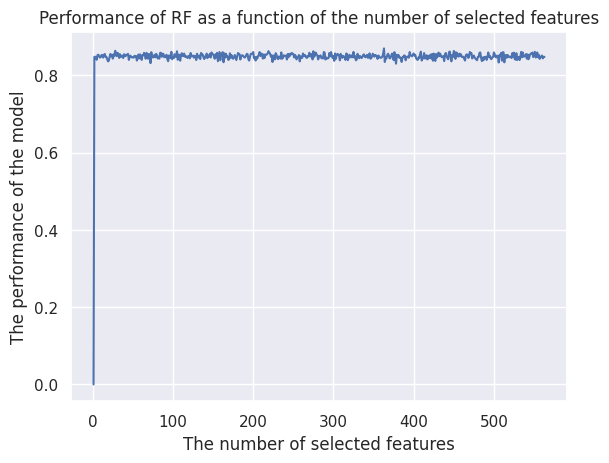

We obtain the best score for the model with 362 features


In [ ]:
val_scores = np.zeros(len(rf_selection))
rf = RandomForestClassifier(n_estimators=25, min_samples_leaf=2, criterion='entropy')

for i in tqdm(range(1, X.shape[1])):
  features_selec = rf_selection[:i] # We conserve the best i Features
  X_tmp = X[:, features_selec]
  model_perf = score_model(X, y, rf, n_iter=100)
  val_scores[i] = model_perf

plt.plot(range(1, len(val_scores)+1), val_scores)
plt.title('Performance of RF as a function of the number of selected features')
plt.xlabel('The number of selected features')
plt.ylabel('The performance of the model')
plt.show()

print(f'We obtain the best score for the model with {np.argmax(val_scores)} features')

We see that the perormance of the model reaches fastly a maximum with some of noise because this is random. The goal is to take the less feature as possible because in that way we won't chose irrelevant features for classification.

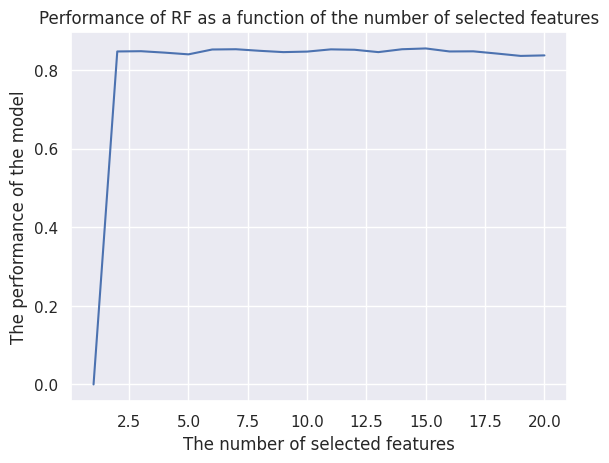

In [ ]:
plt.plot(range(1, 21), val_scores[:20])
plt.title('Performance of RF as a function of the number of selected features')
plt.xlabel('The number of selected features')
plt.ylabel('The performance of the model')
plt.show()

I think, chosing the twenty best features could be a good choice, let's see them.

In [ ]:
# Let's see the best 10 features with this method
for name_feature in features_train.columns[rf_selection[:20]]:
  print(name_feature)

lv_ejec_frac
rv_over_lv_es
original_shape_SurfaceVolumeRatio_lv_es
rv_over_lv_ed
myo_over_lv_es
original_shape_VoxelVolume_lv_es
original_shape_LeastAxisLength_lv_es
original_shape_SurfaceArea_lv_es
original_shape_Sphericity_myo_es
original_shape_MinorAxisLength_lv_es
original_shape_MinorAxisLength_myo_es
myo_thickness_ed
original_shape_SurfaceVolumeRatio_myo_es
myo_thickness_es
original_shape_LeastAxisLength_myo_es
original_shape_Maximum2DDiameterSlice_lv_es
original_shape_VoxelVolume_rv_es
original_shape_LeastAxisLength_lv_ed
rv_ejec_frac
myo_over_lv_ed


These are just shape-based features.

In [ ]:
# We compute the selected features
n_features_sel = 20
X_selected = X[:, rf_selection[:n_features_sel]]
X_test_selected = X_test[:, rf_selection[:n_features_sel]]
print(f'There are {X_selected.shape[1]} features.')

There are 20 features.


## 7.4. The final classification

In this section, we find the best hyperparameters, we train with all our train set and do the last predictions, the last one I submitted.

In [ ]:
# Hyperparameters to test 
p_grid_rf = {'n_estimators': [10, 25, 50, 100, 200], 'min_samples_leaf': [2, 3, 4, 5], 'criterion' : ['entropy', 'gini']}   
rf = RandomForestClassifier()

# Get the best hyperparameters with my function
best_params_rf = get_best_hypperparameters(rf, p_grid_rf, X_selected, y)
print(f'\nThe best parameters are: {best_params_rf}')

100%|██████████| 25/25 [12:42<00:00, 30.52s/it]



The best parameters are: {'n_estimators': 50, 'min_samples_leaf': 3, 'criterion': 'entropy'}


In [ ]:
best_rf = RandomForestClassifier(n_estimators=best_params_rf['n_estimators'], min_samples_leaf=best_params_rf['min_samples_leaf'], criterion=best_params_rf['criterion'])
val_score_rf = score_model(X_selected, y, best_rf, n_iter=50)
print(f'The score of the RF is: {val_score_rf}')
y_test = get_prediction(best_rf, X_selected, y, X_test_selected)

The score of the RF is: 0.9286666666666663


100%|██████████| 20/20 [00:01<00:00, 10.53it/s]


# 8. Conclusion

In this challenge, we explore different ways to extract features and to chose the right classification model. We did not use deep learning to extract features (because I did not have the time) nor to classify because I did have really bad results with that and I did not see the use of Deep Learning in articles to classify everything. 

We saw espacially a 'new' method to chose the best hyperparameters and we did a first look at the library Radiomics. 

However we have disappointing results when we add features generated by Radiomics and I don't really understand why. Maybe, the features are wrongly computed because of a wrong configuration. As far as I know, the volume was correctly computed taking into account the voxel size (I have compared the volumes that I have computed and the volumes that I extracted from Radiomics).

If I hadn't caught myself at the last minute, I would have explored other way to extract features, and I had in mind the use of a pretrained model for shape recognition. 

Moreover, this was the first challenge for me and I did not notice that the score we see was on only 15 test patients and that could be not relevant. I tried to maximize this score without following all the methodology I presented in this report. I did everything but not always in the right order.